# Problem 1

## Gillespie's Algorithm

### Imports and Helper Functions

In [160]:
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import solve_ivp
import seaborn as sns

def standardize_timesteps(data: list[list[float]], data_rate: float, max_t: int) -> np.ndarray:
    t_list = np.array(data[0])
    new_t_list = np.linspace(0, max_t, data_rate * max_t)
    result = np.zeros((len(data), len(new_t_list)))
    result[0] = new_t_list
    for i in range(1, len(data)):
        result[i] = np.interp(new_t_list, t_list, data[i])

    return result

### Classes

In [161]:
class Population:
    def __init__(self, initial_X, initial_Y, initial_Z):
        self.X = initial_X
        self.Y = initial_Y
        self.Z = initial_Z

    def __str__(self):
        return f"X = {self.X}, Y = {self.Y}, Z = {self.Z}"

    def N(self):
        return self.X + self.Y + self.Z
    
    def tuple(self):
        return (self.X, self.Y, self.Z)

class Gillespie_Parameters:
    def __init__(self, population_size, initial_infected, beta, gamma, mu, epsilon=0):
        self.population = Population(population_size - initial_infected, initial_infected, 0)
        self.beta = beta
        self.gamma = gamma
        self.mu = mu
        self.epsilon = epsilon
        self.r0 = beta / (gamma + mu)

    def __str__(self):
        return f"r0 = {self.r0:.2f}, beta = {self.beta:.2f}, gamma = {self.gamma:.2f}, mu = {self.mu:.2f}, epsilon = {self.epsilon:.5f}, N = {self.population.N()}"

class Event:
    def __init__(self, name, rate_function, result_function):
        self.name = name
        self.rate_function = rate_function
        self.result_function = result_function

    def get_rate(self, params: Gillespie_Parameters):
        return self.rate_function(params)
    
    def execute_result(self, population: Population):
        return self.result_function(population)

### Define the events

In [162]:
def _birth_rate(params: Gillespie_Parameters):
    return params.mu * params.population.N()
def _birth_result(pop: Population) -> Population:
    pop.X += 1
BirthEvent = Event('birth', _birth_rate, _birth_result)

def _transmission_rate(params: Gillespie_Parameters):
    return params.beta * params.population.X * params.population.Y / params.population.N()
def _transmission_result(pop: Population) -> Population:
    pop.X -= 1
    pop.Y += 1
TransmissionEvent = Event('transmission', _transmission_rate, _transmission_result)

def _recovery_rate(params: Gillespie_Parameters):
    return params.gamma * params.population.Y
def _recovery_result(pop: Population) -> Population:
    pop.Y -= 1
    pop.Z += 1
RecoveryEvent = Event('recovery', _recovery_rate, _recovery_result)

def _death_x_rate(params: Gillespie_Parameters):
    return params.mu * params.population.X
def _death_x_result(pop: Population) -> Population:
    pop.X -= 1
DeathXEvent = Event('death_x', _death_x_rate, _death_x_result)

def _death_y_rate(params: Gillespie_Parameters):
    return params.mu * params.population.Y
def _death_y_result(pop: Population) -> Population:
    pop.Y -= 1
DeathYEvent = Event('death_y', _death_y_rate, _death_y_result)

def _death_z_rate(params: Gillespie_Parameters):
    return params.mu * params.population.Z
def _death_z_result(pop: Population) -> Population:
    pop.Z -= 1
DeathZEvent = Event('death_z', _death_z_rate, _death_z_result)

def _import_rate(params: Gillespie_Parameters):
    if params.population.X == 0:
        return 0
    return params.epsilon * np.sqrt(params.population.N())
def _import_result(pop: Population) -> Population:
    pop.Y += 1
    pop.X -= 1
ImportEvent = Event('import', _import_rate, _import_result)

events = [BirthEvent, TransmissionEvent, RecoveryEvent, DeathXEvent, DeathYEvent, DeathZEvent]

### Prepare Gillespie Simulation

In [163]:
class Result:
    def __init__(self, results: np.ndarray):
        self.t = results[0]
        self.X = results[1]
        self.Y = results[2]
        self.Z = results[3]

    def s_i_covariance(self):
        return np.cov(self.X, self.Y)[0][1]

class Results:
    def __init__(self, t: np.ndarray):
        self.t = t
        self.Xs = np.ndarray((0, len(t)))
        self.Ys = np.ndarray((0, len(t)))
        self.Zs = np.ndarray((0, len(t)))
    
    def add_result(self, result: Result):
        if result.t[0] != self.t[0]:
            raise ValueError('All results must have the same timesteps')
        self.Xs = np.vstack((self.Xs, result.X))
        self.Ys = np.vstack((self.Ys, result.Y))
        self.Zs = np.vstack((self.Zs, result.Z))

    def mean_result(self):
        return Result(np.array([self.t, np.mean(self.Xs, axis=0), np.mean(self.Ys, axis=0), np.mean(self.Zs, axis=0)]))

    def mean_and_std_infected(self):
        return np.mean(self.Ys, axis=0), np.std(self.Ys, axis=0)
    
    def mean_and_minmax_infected(self):
        minmax = np.zeros((2, len(self.t)))
        minmax[0] = np.min(self.Ys, axis=0)
        minmax[1] = np.max(self.Ys, axis=0)
        return np.mean(self.Ys, axis=0), minmax

def get_rates(events: list[Event], params: Gillespie_Parameters):
    return [e.get_rate(params) for e in events]

def get_delta_ts(rates: list[float]):
    rands = np.random.rand(len(rates))
    while 0 in rands: # avoid zeros
        rands = np.random.rand(len(rates))
    delta_ts = np.full(len(rates), np.inf)
    for i, r in enumerate(rates):
        if r == 0:
            continue
        delta_ts[i] = (-1 / r) * np.log(rands[i])
    return delta_ts


def gillespie(params: Gillespie_Parameters, events: list[Event], t_max) -> list[list[float]]:
    t = 0.0
    params
    results = [[], [], [], []] # t, X, Y, Z
    pop = copy.deepcopy(params.population)
    extinct = False
    while t < t_max and params.population.N() > 0:
        rates = get_rates(events, params)
        delta_ts = get_delta_ts(rates)
        event_index = np.argmin(delta_ts)
        t += delta_ts[event_index]
        events[event_index].execute_result(params.population)
        if not extinct and params.population.Y == 0:
            print(f'Extinction at t={t:.2f}')
            extinct = True
        if extinct and params.population.Y >= 2:
            print(f'Import at t={t:.2f}')
            extinct = False
        results[0].append(t)
        results[1].append(params.population.X)
        results[2].append(params.population.Y)
        results[3].append(params.population.Z)
        # print(f'{events[event_index].name} at t={t}, {params.population}')
    params.population = pop
    return results

class Experiment:
    def __init__(self, params: Gillespie_Parameters, events: list[Event], simulation_length: int, data_rate=1, min_iterations=5, max_iterations=1, target_rse=0.05, store_raw=False):
        self.params = params
        self.events = events
        self.simulation_length = simulation_length
        self.data_rate = data_rate
        self.min_iterations = min_iterations
        self.max_iterations = max_iterations
        self.store_raw = store_raw
        self.target_rse = target_rse
        self.standard_t = np.linspace(0, self.simulation_length, self.simulation_length * self.data_rate)

    def run(self):
        print(f'Running experiment: {str(self.params)}')
        self.raw_results = [] if self.store_raw else None
        self.results = Results(self.standard_t)
        self.extinction_counts = np.zeros(self.max_iterations)
        self.rses = np.full(self.max_iterations, np.nan, dtype=float)
        for i in range(self.max_iterations):
            start = time.perf_counter()
            raw_result = gillespie(self.params, self.events, self.simulation_length)
            if self.store_raw:
                self.raw_results.append(raw_result)
            extinct = False
            for j in range(len(raw_result[2])):
                if not extinct and raw_result[2][j] == 0:
                    extinct = True
                    self.extinction_counts[i] += 1
                if extinct and raw_result[2][j] >= 2:
                    extinct = False
            self.results.add_result(Result(standardize_timesteps(raw_result, self.data_rate, self.simulation_length)))
            rse = self.avg_rse_infected()
            self.rses[i] = rse
            end = time.perf_counter()
            print(f'Ran iteration {i+1} in {(end - start):.2f} seconds, rse={rse:.3f}')
            if i+1 >= self.min_iterations and rse < self.target_rse:
                break
        return self.results
    
    def integrate_deterministic_sir(self, deterministic_sir_function):
        return solve_ivp(
            deterministic_sir_function,
            (0, self.simulation_length),
            self.params.population.tuple(),
            t_eval=np.linspace(0, self.simulation_length, self.simulation_length * self.data_rate),
            args=(self.params.beta, self.params.gamma, self.params.mu))
    
    def avg_rse_infected(self):
        if len(self.results.Ys) <= 1:
            return 0.0
        mean, std = self.results.mean_and_std_infected()
        stderr = std / np.sqrt(len(self.results.Ys))
        nz_mean = mean != 0
        return np.mean(stderr[nz_mean] / mean[nz_mean])

        
  
class Experiments:
    def __init__(self, experiments: list[Experiment]):
        self.experiments = experiments

    def run(self):
        for e in self.experiments:
            e.run()

### Run Gillespie

Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 5000.0
Ran iteration 1 in 0.70 seconds, rse=0.000


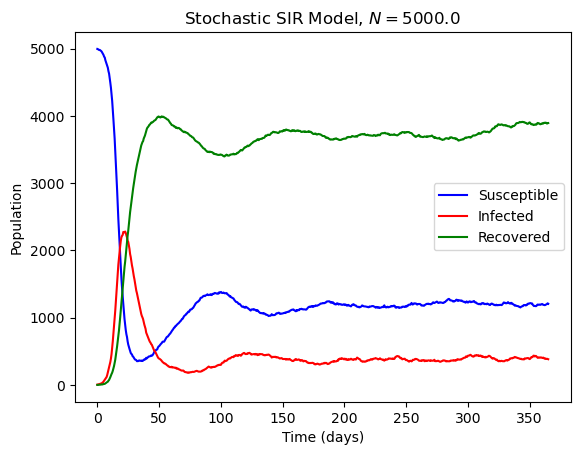

In [211]:
population_size = 5e3
initial_infected = 5
sim_length = 365
data_rate = 2
beta = 0.5
gamma = 0.1
mu = 1/100

experiment1 = Experiment(Gillespie_Parameters(population_size=population_size, initial_infected=initial_infected, beta=beta, gamma=gamma, mu=mu), events=events, simulation_length=sim_length, data_rate=data_rate)

r0 = beta / (gamma + mu)

res = experiment1.run().mean_result()

plt.plot(res.t, res.X, 'b', label='Susceptible')
plt.plot(res.t, res.Y, 'r', label='Infected')
plt.plot(res.t, res.Z, 'g', label='Recovered')
plt.legend(loc='right')
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.title(f'Stochastic SIR Model, $N={population_size}$')
plt.show()

## Compare to deterministic model

Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 1000.0
Ran iteration 1 in 0.14 seconds, rse=0.000
Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 10000.0
Ran iteration 1 in 1.38 seconds, rse=0.000
Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 100000.0
Ran iteration 1 in 12.96 seconds, rse=0.000
Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 1000000.0
Ran iteration 1 in 125.66 seconds, rse=0.000


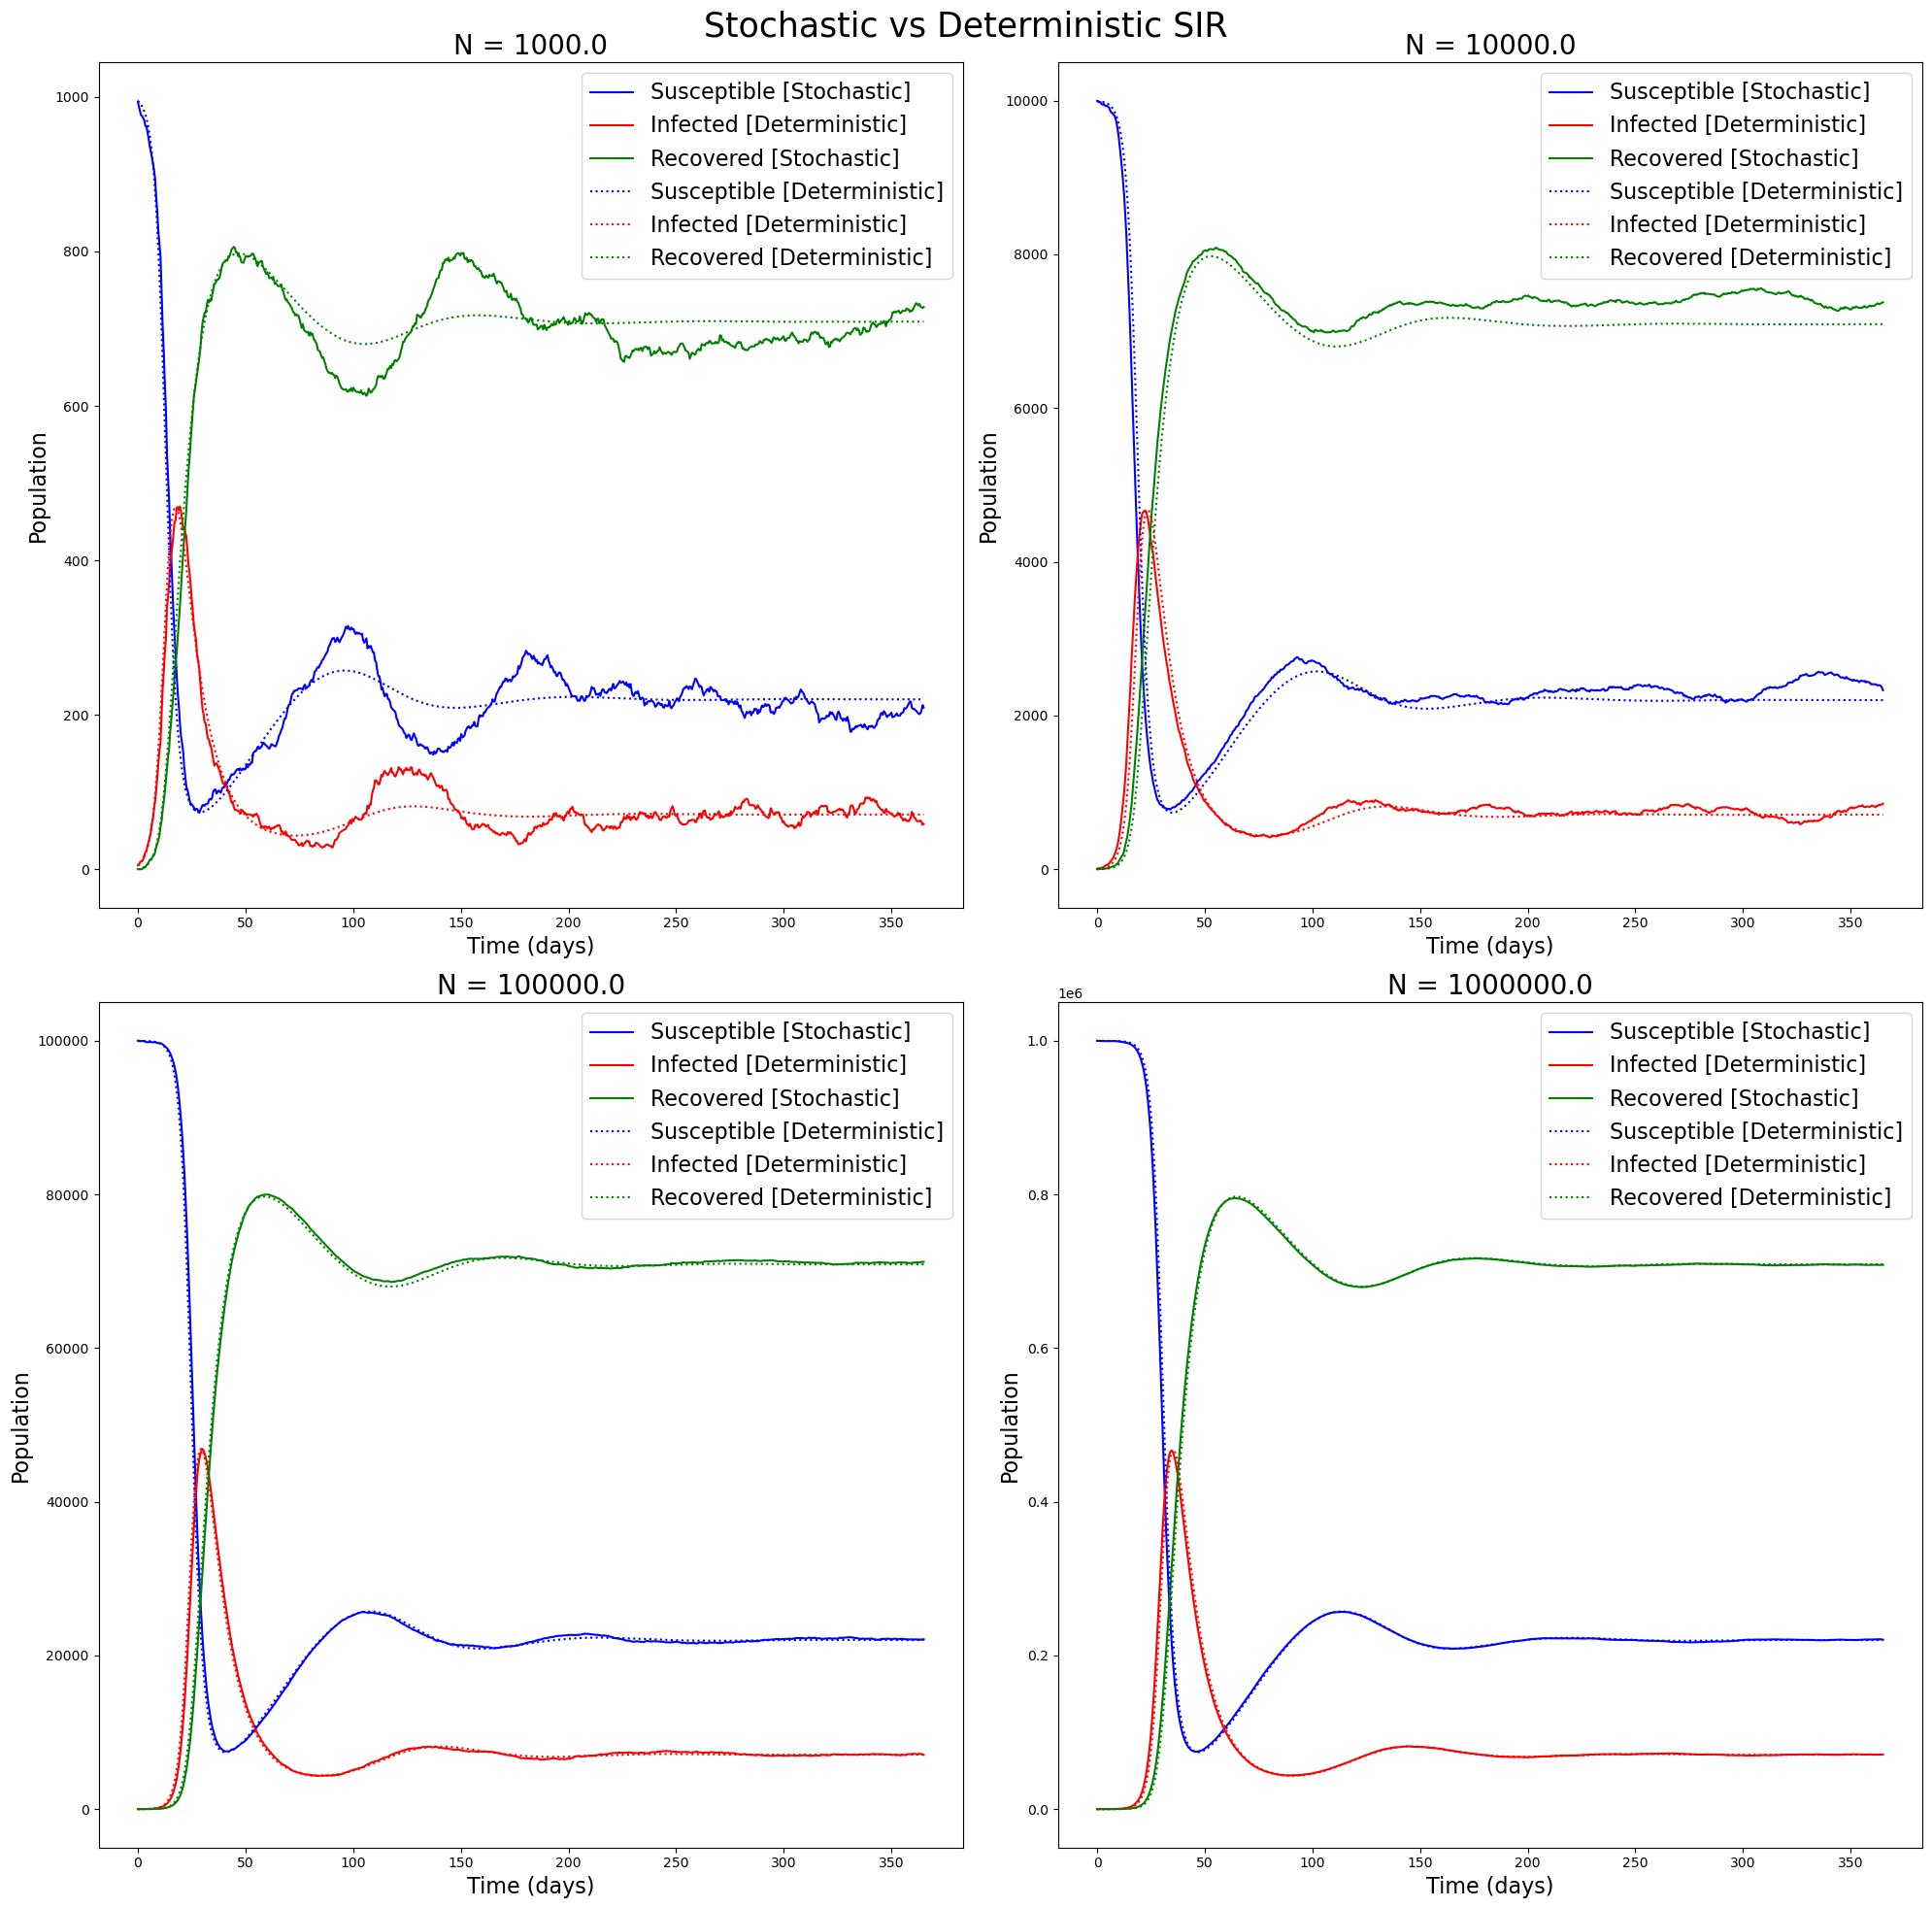

In [ ]:
def deterministic_sir(t, xyz, beta, gamma, mu):
    x, y, z = xyz
    n = x + y + z
    dxdt = mu * n - beta * (x/n) * y - mu * x
    dydt = beta * (x/n) * y - gamma * y - mu * y
    dzdt = gamma * y - mu * z
    return [dxdt, dydt, dzdt]

ns = [1e3, 1e4, 1e5, 1e6]
fig, ax = plt.subplots(2, 2, figsize=(20, 20))
for i, n in enumerate(ns):
    params = Gillespie_Parameters(population_size=n, initial_infected=initial_infected, beta=0.5, gamma=0.1, mu=0.01)
    experiment = Experiment(params, events, sim_length, data_rate=data_rate)
    res = experiment.run().mean_result()
    sol = experiment.integrate_deterministic_sir(deterministic_sir)

    ax[int(i/2), i%2].plot(res.t, res.X, 'b', label='Susceptible [Stochastic]')
    ax[int(i/2), i%2].plot(res.t, res.Y, 'r', label='Infected [Deterministic]')
    ax[int(i/2), i%2].plot(res.t, res.Z, 'g', label='Recovered [Stochastic]')
    ax[int(i/2), i%2].plot(sol.t, sol.y[0], 'b:', label='Susceptible [Deterministic]')
    ax[int(i/2), i%2].plot(sol.t, sol.y[1], 'r:', label='Infected [Deterministic]')
    ax[int(i/2), i%2].plot(sol.t, sol.y[2], 'g:', label='Recovered [Deterministic]')
    ax[int(i/2), i%2].legend(fontsize=16)
    ax[int(i/2), i%2].set_title(f'N = {n}', fontsize=20)
    ax[int(i/2), i%2].set_xlabel('Time (days)', fontsize=16)
    ax[int(i/2), i%2].set_ylabel('Population', fontsize=16)

plt.suptitle('Stochastic vs Deterministic SIR', fontsize=25)
plt.tight_layout()
plt.savefig('./plots/event_based/stochastic-vs-deterministic-sir.png')
plt.show()

## Vary Gillespie parameters

### Vary $R_0$ 

In [ ]:
r0s = np.arange(0.5, 10.5, 0.5)
max_iterations = 100

r0experiments = Experiments([])
for r0 in r0s:
    r0experiments.experiments.append(Experiment(Gillespie_Parameters(population_size, initial_infected, beta=r0 * (gamma + mu), gamma=gamma, mu=mu), events=events, simulation_length=sim_length, data_rate=data_rate, max_iterations=max_iterations))
r0experiments.run()

Running experiment: r0 = 0.50, beta = 0.06, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 5000.0
Extinction at t=35.47
Ran iteration 1 in 0.28 seconds, rse=0.000
Extinction at t=22.57
Ran iteration 2 in 0.25 seconds, rse=0.356
Extinction at t=48.79
Ran iteration 3 in 0.28 seconds, rse=0.404
Extinction at t=24.28
Ran iteration 4 in 0.28 seconds, rse=0.447
Extinction at t=20.55
Ran iteration 5 in 0.28 seconds, rse=0.465
Extinction at t=17.15
Ran iteration 6 in 0.28 seconds, rse=0.486
Extinction at t=55.92
Ran iteration 7 in 0.28 seconds, rse=0.456
Extinction at t=22.63
Ran iteration 8 in 0.25 seconds, rse=0.457
Extinction at t=57.10
Ran iteration 9 in 0.29 seconds, rse=0.384
Extinction at t=22.64
Ran iteration 10 in 0.27 seconds, rse=0.388
Extinction at t=13.17
Ran iteration 11 in 0.27 seconds, rse=0.398
Extinction at t=9.72
Ran iteration 12 in 0.28 seconds, rse=0.408
Extinction at t=36.04
Ran iteration 13 in 0.29 seconds, rse=0.393
Extinction at t=34.45
Ran iteration 14 in 0.28 second

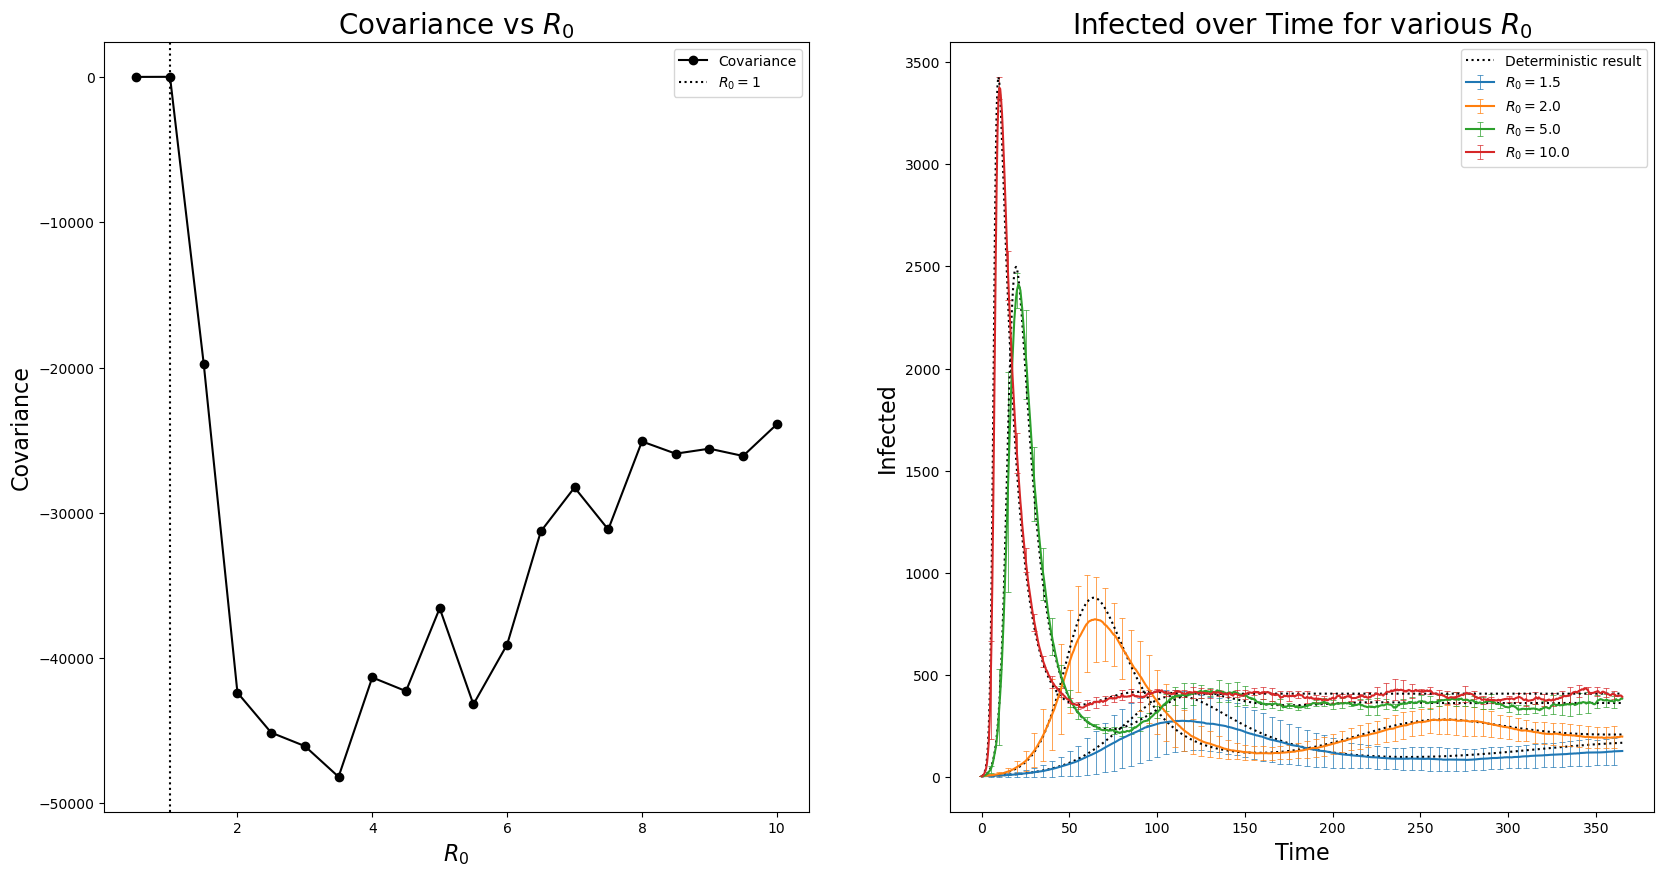

In [ ]:
# plot covariance

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.title('Covariance vs $R_0$', fontsize=20)
plt.xlabel('$R_0$', fontsize=16)
plt.ylabel('Covariance', fontsize=16)
# plt.yscale('symlog')

covs = []
for ex in r0experiments.experiments:
    mean = ex.results.mean_result()
    covs.append(mean.s_i_covariance())
plt.plot(r0s, covs, 'ko-', label='Covariance')
plt.axvline(1, color='k', linestyle=':', label='$R_0=1$')
plt.legend()

graphed_r0s = [1.5, 2.0, 5.0, 10.0]
plt.subplot(1, 2, 2)
labeled = False
for ex in r0experiments.experiments:
    if ex.params.r0 not in graphed_r0s:
        continue
    mean, err = ex.results.mean_and_std_infected()
    plt.errorbar(ex.results.t, mean, yerr=err, errorevery=10, capsize=2, elinewidth=0.5, capthick=0.5, label=f"$R_0={ex.params.r0}$")
    det = ex.integrate_deterministic_sir(deterministic_sir)
    detlabel = '_'
    if not labeled:
        labeled = True
        detlabel = 'Deterministic result'
    plt.plot(det.t, det.y[1], 'k:', label=detlabel)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected", fontsize=16)
plt.title(f'Infected over Time for various $R_0$' , fontsize=20)
plt.legend()
plt.savefig('./plots/event_based/r0.png')
plt.show()

### Varying $\gamma$

In [ ]:
gammas = np.arange(0.05, 1.05, 0.05)
r0 = 5.0

gamma_experiments = Experiments([])
for g in gammas:
    gamma_experiments.experiments.append(Experiment(Gillespie_Parameters(population_size, initial_infected, beta=r0*(g+mu), gamma=g, mu=mu), events=events, simulation_length=sim_length, data_rate=data_rate, max_iterations=max_iterations))
gamma_experiments.run()

Running experiment: r0 = 5.00, beta = 0.30, gamma = 0.05, mu = 0.01, epsilon = 0.00000, N = 5000.0
Ran iteration 1 in 0.68 seconds, rse=0.000
Ran iteration 2 in 0.68 seconds, rse=0.069
Ran iteration 3 in 0.64 seconds, rse=0.062
Ran iteration 4 in 0.67 seconds, rse=0.052
Ran iteration 5 in 0.63 seconds, rse=0.047
Running experiment: r0 = 5.00, beta = 0.55, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 5000.0
Ran iteration 1 in 0.66 seconds, rse=0.000
Ran iteration 2 in 0.66 seconds, rse=0.033
Ran iteration 3 in 0.66 seconds, rse=0.039
Ran iteration 4 in 0.67 seconds, rse=0.047
Ran iteration 5 in 0.67 seconds, rse=0.042
Running experiment: r0 = 5.00, beta = 0.80, gamma = 0.15, mu = 0.01, epsilon = 0.00000, N = 5000.0
Ran iteration 1 in 0.66 seconds, rse=0.000
Ran iteration 2 in 0.68 seconds, rse=0.063
Ran iteration 3 in 0.67 seconds, rse=0.069
Ran iteration 4 in 0.71 seconds, rse=0.071
Ran iteration 5 in 0.67 seconds, rse=0.065
Ran iteration 6 in 0.77 seconds, rse=0.058
Ran iteration 7

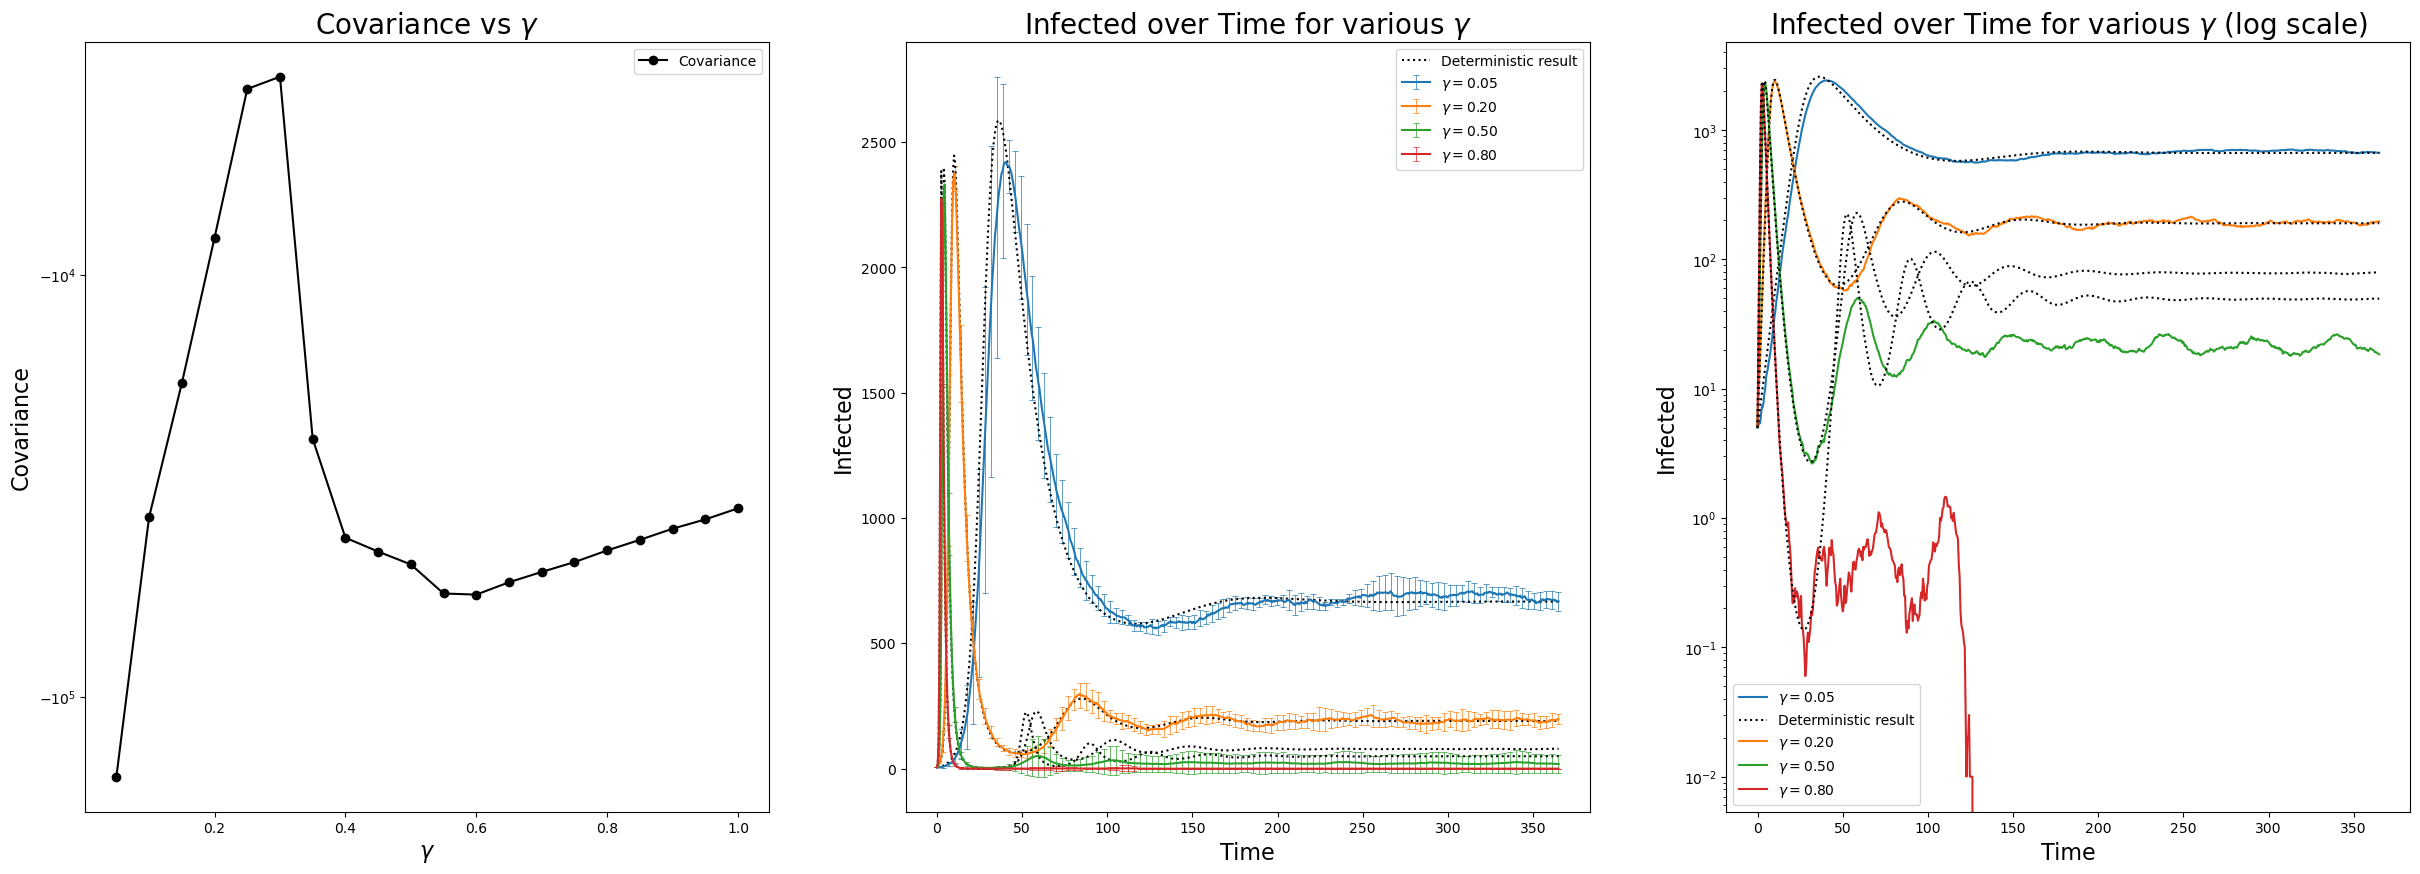

In [ ]:
# plot covariance

plt.figure(figsize=(30, 10))
plt.subplot(1, 3, 1)
plt.title('Covariance vs $\gamma$', fontsize=20)
plt.xlabel('$\gamma$', fontsize=16)
plt.ylabel('Covariance', fontsize=16)
plt.yscale('symlog')

covs = []
for ex in gamma_experiments.experiments:
    mean = ex.results.mean_result()
    covs.append(mean.s_i_covariance())
plt.plot(gammas, covs, 'ko-', label='Covariance')
plt.legend()

plt.subplot(1, 3, 2)
graphed_gammas = [0.05, 0.2, 0.5, 0.8]
labeled = False
for ex in gamma_experiments.experiments:
    if np.round(ex.params.gamma, 2) not in graphed_gammas:
        continue
    mean, err = ex.results.mean_and_std_infected()
    errbar = plt.errorbar(ex.results.t, mean, yerr=err, errorevery=7, capsize=2, elinewidth=0.5, capthick=0.5, label=f"$\gamma={ex.params.gamma:.2f}$")
    det = ex.integrate_deterministic_sir(deterministic_sir)
    detlabel = '_'
    if not labeled:
        labeled = True
        detlabel = 'Deterministic result'
    plt.plot(det.t, det.y[1], 'k:', label=detlabel)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected", fontsize=16)
plt.title(f'Infected over Time for various $\\gamma$', fontsize=20)
plt.legend()

plt.subplot(1, 3, 3)
labeled = False
for ex in gamma_experiments.experiments:
    if np.round(ex.params.gamma, 2) not in graphed_gammas:
        continue
    mean, err = ex.results.mean_and_std_infected()
    errbar = plt.plot(ex.results.t, mean, label=f"$\gamma={ex.params.gamma:.2f}$")
    det = ex.integrate_deterministic_sir(deterministic_sir)
    detlabel = '_'
    if not labeled:
        labeled = True
        detlabel = 'Deterministic result'
    plt.plot(det.t, det.y[1], 'k:', label=detlabel)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected", fontsize=16)
plt.yscale('log')
plt.title(f'Infected over Time for various $\\gamma$ (log scale)', fontsize=20)
plt.legend()

plt.savefig('./plots/event_based/gamma.png')
plt.show()

### Varying N

In [ ]:
ns = [5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 5e5]
iterations = 20
r0 = 5.0

n_experiments = Experiments([])
for n in ns:
    n_experiments.experiments.append(Experiment(Gillespie_Parameters(n, initial_infected, beta=beta, gamma=gamma, mu=mu), events=events, simulation_length=sim_length, data_rate=data_rate, max_iterations=max_iterations))
n_experiments.run()

Running experiment: r0 = 4.55, beta = 0.50, gamma = 0.10, mu = 0.01, epsilon = 0.00000, N = 500.0
Ran iteration 1 in 0.08 seconds, rse=0.000
Ran iteration 2 in 0.07 seconds, rse=0.178
Ran iteration 3 in 0.07 seconds, rse=0.162
Ran iteration 4 in 0.08 seconds, rse=0.149
Ran iteration 5 in 0.06 seconds, rse=0.149
Ran iteration 6 in 0.06 seconds, rse=0.137
Ran iteration 7 in 0.06 seconds, rse=0.127
Ran iteration 8 in 0.07 seconds, rse=0.119
Ran iteration 9 in 0.07 seconds, rse=0.113
Ran iteration 10 in 0.06 seconds, rse=0.112
Ran iteration 11 in 0.07 seconds, rse=0.104
Ran iteration 12 in 0.07 seconds, rse=0.099
Ran iteration 13 in 0.08 seconds, rse=0.096
Ran iteration 14 in 0.07 seconds, rse=0.090
Ran iteration 15 in 0.07 seconds, rse=0.087
Ran iteration 16 in 0.06 seconds, rse=0.084
Ran iteration 17 in 0.07 seconds, rse=0.081
Ran iteration 18 in 0.07 seconds, rse=0.078
Ran iteration 19 in 0.07 seconds, rse=0.076
Ran iteration 20 in 0.07 seconds, rse=0.073
Ran iteration 21 in 0.06 second

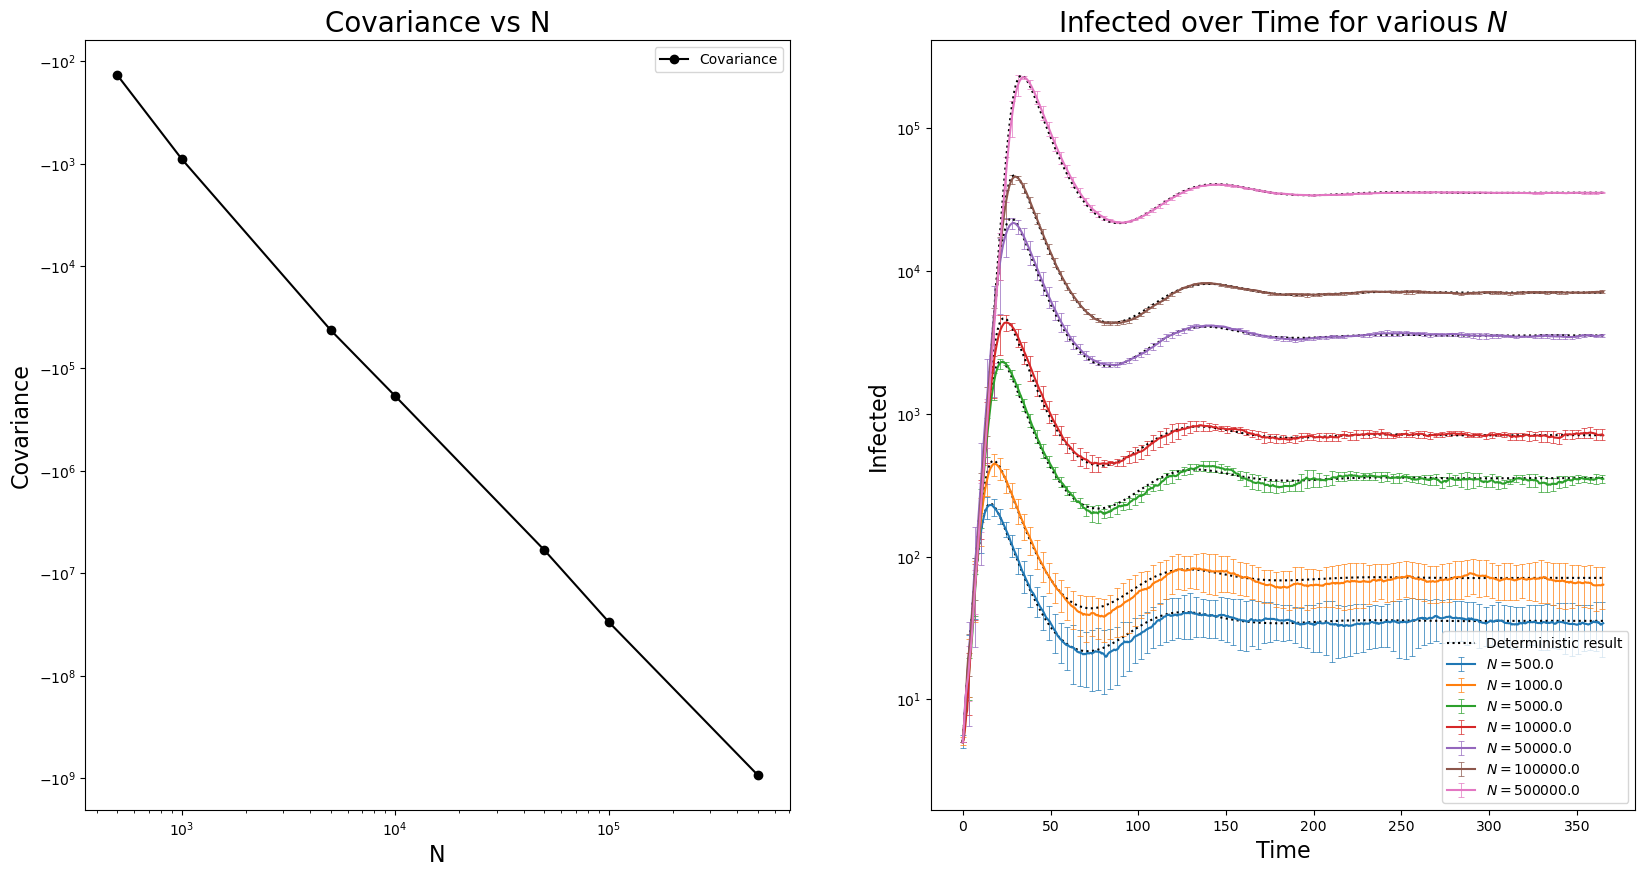

In [ ]:
# plot covariance

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title('Covariance vs N', fontsize=20)
plt.xlabel('N', fontsize=16)
plt.ylabel('Covariance', fontsize=16)
plt.yscale('symlog')
plt.xscale('log')

covs = []
for ex in n_experiments.experiments:
    mean = ex.results.mean_result()
    covs.append(mean.s_i_covariance())
plt.plot(ns, covs, 'ko-', label='Covariance')
plt.legend()

plt.subplot(1, 2, 2)
plt.yscale('symlog')
labeled = False
for ex in n_experiments.experiments:
    mean, err = ex.results.mean_and_std_infected()
    plt.errorbar(ex.results.t, mean, yerr=err, errorevery=7, capsize=2, elinewidth=0.5, capthick=0.5, label=f"$N={ex.params.population.N()}$")
    det = ex.integrate_deterministic_sir(deterministic_sir)
    detlabel = '_'
    if not labeled:
        labeled = True
        detlabel = 'Deterministic result'
    plt.plot(det.t, det.y[1], 'k:', label=detlabel)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Infected", fontsize=16)
plt.title(f'Infected over Time for various $N$', fontsize=20)
plt.legend()
plt.savefig('./plots/event_based/n.png')
plt.show()

## Extinctions

### N

In [ ]:
ns = np.linspace(1e2, 1e3, 10)
r0_ext = 5
gamma_ext = 0.2
mu_ext = 0.01
epsilon_base = 0.2/365

max_iterations_ext = 100

sim_years_ext = 1
data_rate_ext = 1

events_with_imports = copy.copy(events)
events_with_imports.append(ImportEvent)
experiment_list = []


for n in ns:
    experiment_list.append(Experiment(Gillespie_Parameters(n, initial_infected, r0_ext * (gamma_ext + mu_ext), gamma_ext, mu_ext, epsilon=epsilon_base), events=events_with_imports, simulation_length=sim_length * sim_years_ext, data_rate=data_rate_ext, max_iterations=max_iterations_ext))
experiments_ext_n = Experiments(experiment_list)
experiments_ext_n.run()


Running experiment: r0 = 5.00, beta = 1.05, gamma = 0.20, mu = 0.01, epsilon = 0.00055, N = 100.0
Extinction at t=76.62
Import at t=336.18
Ran iteration 1 in 0.02 seconds, rse=0.000
Extinction at t=33.11
Import at t=45.22
Extinction at t=80.08
Import at t=334.96
Extinction at t=337.80
Ran iteration 2 in 0.01 seconds, rse=0.451
Extinction at t=30.56
Import at t=85.22
Extinction at t=86.92
Import at t=206.60
Extinction at t=241.79
Ran iteration 3 in 0.01 seconds, rse=0.627
Extinction at t=52.57
Import at t=121.71
Extinction at t=141.13
Ran iteration 4 in 0.01 seconds, rse=0.654
Extinction at t=27.87
Import at t=261.02
Extinction at t=351.84
Ran iteration 5 in 0.01 seconds, rse=0.738
Extinction at t=41.54
Import at t=309.62
Extinction at t=333.99
Ran iteration 6 in 0.01 seconds, rse=0.726
Extinction at t=35.43
Import at t=163.69
Extinction at t=189.11
Ran iteration 7 in 0.01 seconds, rse=0.753
Extinction at t=45.25
Import at t=236.26
Extinction at t=297.29
Ran iteration 8 in 0.01 seconds,

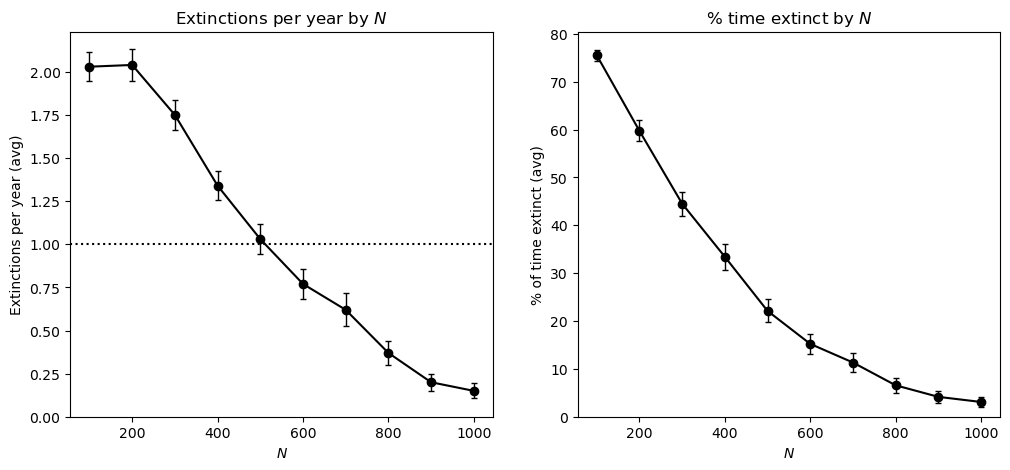

In [ ]:
extinctions_n = np.zeros(len(ns))
extinct_time_n = np.zeros(len(ns))
extinct_time_stderr_n = np.zeros(len(ns))
extinction_stderr_n = np.zeros(len(ns))

for i, n in enumerate(ns):
    ex = experiments_ext_n.experiments[i]
    extinctions_n[i] = np.mean(ex.extinction_counts/sim_years_ext)
    extinction_stderr_n[i] = (np.std(ex.extinction_counts)/np.sqrt(sim_years_ext)) / np.sqrt(len(ex.extinction_counts) * sim_years_ext)
    extinct_time_n[i] = np.average((len(ex.results.t) - np.count_nonzero(ex.results.Ys, axis=1))/len(ex.results.t)) * 100
    extinct_time_stderr_n[i] = (np.std((len(ex.results.t) - np.count_nonzero(ex.results.Ys, axis=1))/len(ex.results.t)) * 100 / np.sqrt(sim_years_ext)) / np.sqrt(len(ex.extinction_counts) * sim_years_ext)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Extinctions per year by $N$')
plt.xlabel('$N$')
plt.ylabel('Extinctions per year (avg)')
# plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.errorbar(ns, extinctions_n, yerr=extinction_stderr_n, fmt='ko-', capsize=2, capthick=1, elinewidth=1)
plt.axhline(y=1.0, color='k', linestyle=':')
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.title('% time extinct by $N$')
plt.xlabel('$N$')
plt.ylabel('% of time extinct (avg)')
# plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
plt.errorbar(ns, extinct_time_n, yerr=extinct_time_stderr_n, fmt='ko-', capsize=2, capthick=1, elinewidth=1)
plt.ylim(bottom=0)
plt.savefig('./plots/event_based/extinction_by_n.png')
plt.show()

### $R_0$

In [ ]:
r0s = np.linspace(1, 10, 10)
n_ext = 5e2

experiment_list = []

for r in r0s:
    experiment_list.append(Experiment(Gillespie_Parameters(n_ext, initial_infected, r * (gamma_ext + mu_ext), gamma_ext, mu_ext, epsilon=epsilon_base), events=events_with_imports, simulation_length=sim_length * sim_years_ext, data_rate=data_rate_ext, max_iterations=max_iterations_ext))
experiments_ext_r0 = Experiments(experiment_list)
experiments_ext_r0.run()

Running experiment: r0 = 1.00, beta = 0.21, gamma = 0.20, mu = 0.01, epsilon = 0.00055, N = 500.0
Extinction at t=82.21
Ran iteration 1 in 0.04 seconds, rse=0.000
Extinction at t=56.89
Import at t=82.55
Extinction at t=85.43
Import at t=277.68
Extinction at t=287.05
Import at t=334.01
Extinction at t=335.05
Ran iteration 2 in 0.04 seconds, rse=0.427
Extinction at t=32.89
Import at t=248.10
Extinction at t=273.33
Import at t=278.95
Extinction at t=287.77
Ran iteration 3 in 0.04 seconds, rse=0.593
Extinction at t=69.45
Import at t=254.25
Extinction at t=259.19
Ran iteration 4 in 0.04 seconds, rse=0.559
Extinction at t=10.06
Ran iteration 5 in 0.03 seconds, rse=0.622
Extinction at t=81.19
Import at t=190.40
Extinction at t=231.88
Import at t=294.41
Extinction at t=297.77
Ran iteration 6 in 0.05 seconds, rse=0.643
Extinction at t=24.02
Import at t=188.46
Extinction at t=206.95
Import at t=345.10
Extinction at t=363.79
Ran iteration 7 in 0.03 seconds, rse=0.671
Extinction at t=130.97
Import

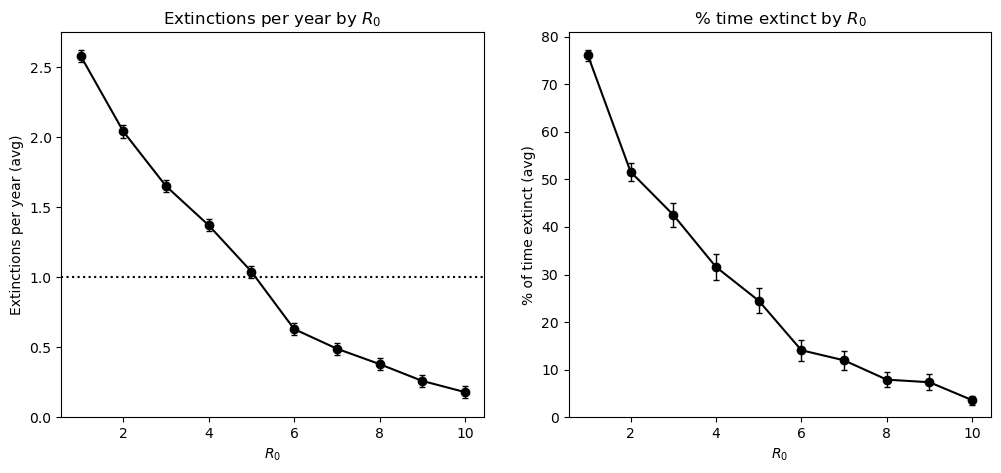

In [ ]:
extinctions_r0 = np.zeros(len(r0s))
extinct_time_r0 = np.zeros(len(r0s))
extinction_stderr_r0 = np.zeros(len(r0s))
extinct_time_stderr_r0 = np.zeros(len(r0s))

for i, n in enumerate(r0s):
    ex = experiments_ext_r0.experiments[i]
    extinctions_r0[i] = np.mean(ex.extinction_counts/sim_years_ext)
    extinction_stderr_r0 = (np.std(ex.extinction_counts)/np.sqrt(sim_years_ext)) / np.sqrt(len(ex.extinction_counts) * sim_years_ext)
    extinct_time_r0[i] = np.average((len(ex.results.t) - np.count_nonzero(ex.results.Ys, axis=1))/len(ex.results.t)) * 100
    extinct_time_stderr_r0[i] = (np.std((len(ex.results.t) - np.count_nonzero(ex.results.Ys, axis=1))/len(ex.results.t)) * 100 / np.sqrt(sim_years_ext)) / np.sqrt(len(ex.extinction_counts) * sim_years_ext)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Extinctions per year by $R_0$')
plt.xlabel('$R_0$')
plt.ylabel('Extinctions per year (avg)')
plt.errorbar(r0s, extinctions_r0, yerr=extinction_stderr_r0, fmt='ko-', capsize=2, capthick=1, elinewidth=1)
plt.axhline(y=1.0, color='k', linestyle=':')
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.title('% time extinct by $R_0$')
plt.xlabel('$R_0$')
plt.ylabel('% of time extinct (avg)')
plt.errorbar(r0s, extinct_time_r0, yerr=extinct_time_stderr_r0, fmt='ko-', capsize=2, capthick=1, elinewidth=1)
plt.ylim(bottom=0)
plt.savefig('./plots/event_based/extinction_by_r0.png')
plt.show()

## Plotting RSE

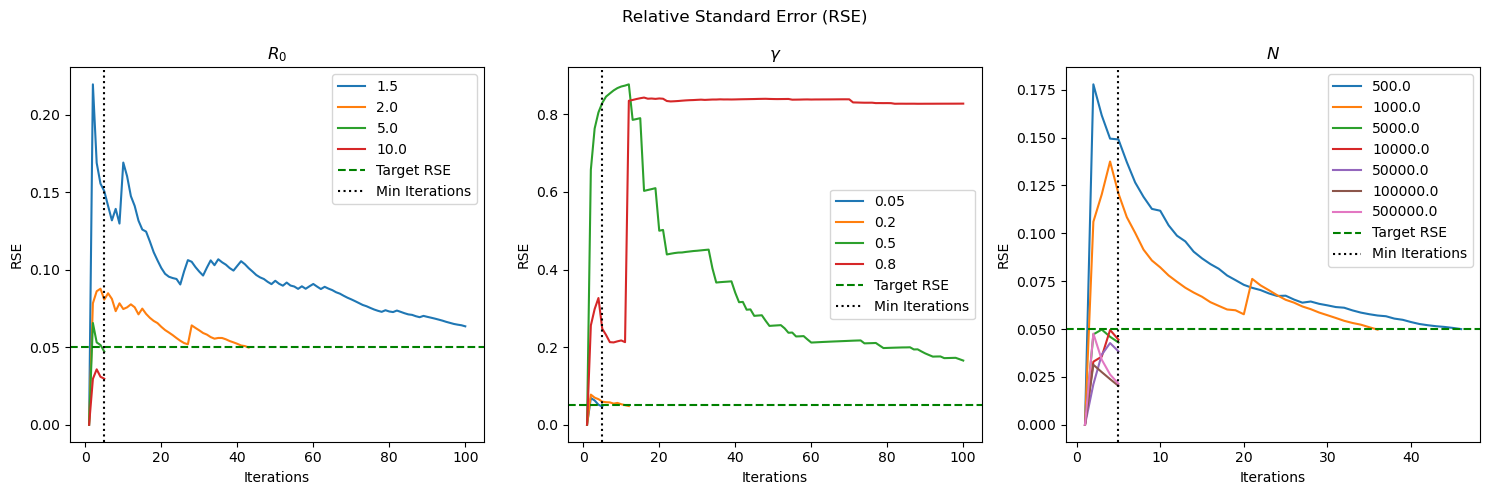

In [ ]:
def plot_rse(ax: plt.Axes, label: str, rse: np.ndarray, max_iter: int, threshold: float):
    ax.plot(np.arange(max_iter)+1, rse, label=label)

# graphed_r0s = [2.0, 3.0, 4.0, 5.0]
n_exp = n_experiments.experiments[0]
gamma_exp = gamma_experiments.experiments[0]

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, r0exp in enumerate(r0experiments.experiments):
    if r0exp.params.r0 not in graphed_r0s:
        continue
    plot_rse(ax[0], str(r0exp.params.r0), r0exp.rses, r0exp.max_iterations, r0exp.target_rse)
ax[0].set_title('$R_0$')
ax[0].set_ylabel('RSE')
ax[0].set_xlabel('Iterations')
ax[0].axhline(r0exp.target_rse, color='g', linestyle='--', label='Target RSE')
ax[0].axvline(r0exp.min_iterations, color='k', linestyle=':', label='Min Iterations')
ax[0].legend()
for i, n_exp in enumerate(n_experiments.experiments):
    plot_rse(ax[2], str(n_exp.params.population.N()), n_exp.rses, n_exp.max_iterations, n_exp.target_rse)
ax[2].set_title('$N$')
ax[2].set_ylabel('RSE')
ax[2].set_xlabel('Iterations')
ax[2].axhline(r0exp.target_rse, color='g', linestyle='--', label='Target RSE')
ax[2].axvline(r0exp.min_iterations, color='k', linestyle=':', label='Min Iterations')
ax[2].legend()
for i, gamma_exp in enumerate(gamma_experiments.experiments):
    if np.round(gamma_exp.params.gamma, 2) not in graphed_gammas:
        continue
    plot_rse(ax[1], str(np.round(gamma_exp.params.gamma, 2)), gamma_exp.rses, gamma_exp.max_iterations, gamma_exp.target_rse)
ax[1].set_title('$\gamma$')
ax[1].set_ylabel('RSE')
ax[1].set_xlabel('Iterations')
ax[1].axhline(r0exp.target_rse, color='g', linestyle='--', label='Target RSE')
ax[1].axvline(r0exp.min_iterations, color='k', linestyle=':', label='Min Iterations')
ax[1].legend()

plt.suptitle('Relative Standard Error (RSE)')

plt.tight_layout()
plt.savefig('./plots/event_based/rse.png')
plt.show()

## Bringing it all together

In [ ]:
events_with_imports = copy.copy(events)
events_with_imports.append(ImportEvent)

high_variance_params = Gillespie_Parameters(1000, 5, beta=1.2, gamma=0.99, mu=0.01, epsilon=0)
low_variance_params = Gillespie_Parameters(500000, 5, beta=1.0, gamma=0.09, mu=0.01, epsilon=0)

high_variance_experiment = Experiment(high_variance_params, events_with_imports, simulation_length=sim_length, min_iterations=20, max_iterations=20)
low_variance_experiment = Experiment(low_variance_params, events_with_imports, simulation_length=sim_length, min_iterations=20, max_iterations=20)

high_variance_experiment.run()
low_variance_experiment.run()

Running experiment: r0 = 1.20, beta = 1.20, gamma = 0.99, mu = 0.01, epsilon = 0.00000, N = 1000
Extinction at t=7.19
Ran iteration 1 in 0.11 seconds, rse=0.000
Extinction at t=24.41
Ran iteration 2 in 0.08 seconds, rse=0.565
Extinction at t=16.38
Ran iteration 3 in 0.08 seconds, rse=0.606
Extinction at t=19.55
Ran iteration 4 in 0.06 seconds, rse=0.566
Extinction at t=17.93
Ran iteration 5 in 0.07 seconds, rse=0.508
Extinction at t=4.08
Ran iteration 6 in 0.06 seconds, rse=0.534
Extinction at t=2.81
Ran iteration 7 in 0.06 seconds, rse=0.554
Extinction at t=5.32
Ran iteration 8 in 0.07 seconds, rse=0.561
Extinction at t=10.93
Ran iteration 9 in 0.06 seconds, rse=0.561
Extinction at t=14.84
Ran iteration 10 in 0.07 seconds, rse=0.545
Extinction at t=0.87
Ran iteration 11 in 0.06 seconds, rse=0.555
Extinction at t=5.19
Ran iteration 12 in 0.06 seconds, rse=0.560
Extinction at t=1.81
Ran iteration 13 in 0.06 seconds, rse=0.566
Extinction at t=7.99
Ran iteration 14 in 0.06 seconds, rse=0.

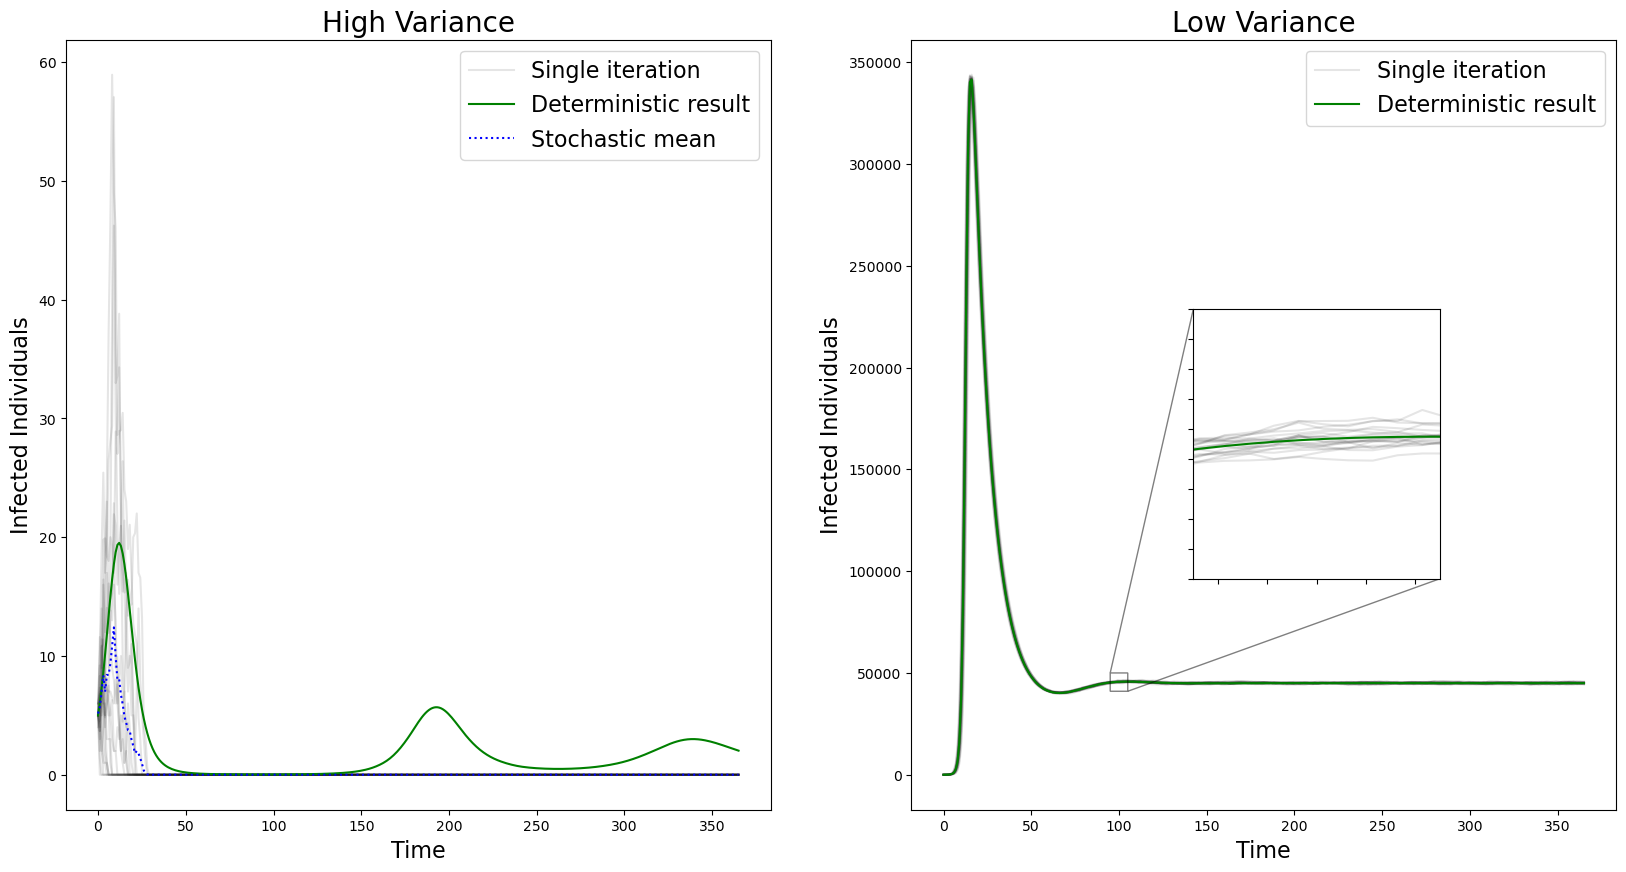

In [210]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1,2,1)
for i, res in enumerate(high_variance_experiment.results.Ys):
    plt.plot(high_variance_experiment.results.t, res, 'k', alpha=0.1, label='Single iteration' if i == 0 else '_')
plt.title('High Variance', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Infected Individuals', fontsize=16)
det = high_variance_experiment.integrate_deterministic_sir(deterministic_sir)
plt.plot(det.t, det.y[1], 'g', label='Deterministic result')
plt.plot(high_variance_experiment.results.t, high_variance_experiment.results.mean_result().Y, 'b:', label='Stochastic mean')
plt.legend(fontsize=16)

ax = plt.subplot(1,2,2)
for i, res in enumerate(low_variance_experiment.results.Ys):
    plt.plot(low_variance_experiment.results.t, res, 'k', alpha=0.1, label='Single iteration' if i == 0 else '_')
plt.title('Low Variance', fontsize=20)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Infected Individuals', fontsize=16)
det = low_variance_experiment.integrate_deterministic_sir(deterministic_sir)
plt.plot(det.t, det.y[1], 'g', label='Deterministic result')

x1, x2, y1, y2 = 95, 105, 41000, 50000 # subregion of the original image
axins = ax.inset_axes(
    [0.4, 0.3, 0.35, 0.35],
    xlim=(x1, x2), ylim=(y1, y2), xticklabels=[], yticklabels=[])
for res in low_variance_experiment.results.Ys:
    axins.plot(low_variance_experiment.results.t, res, 'k', alpha=0.1)
axins.plot(det.t, det.y[1], 'g', label=detlabel)
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.legend(fontsize=16)

plt.savefig('./plots/event_based/high-low.png')
plt.show()

# Problem 2: Spatial Models - Networks
## Implement SIR and Simulate

Watts Strogatz: https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html#networkx.generators.random_graphs.watts_strogatz_graph

Barabasi Albert: https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html#networkx.generators.random_graphs.barabasi_albert_graph

Erdos Reyni: https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html#networkx.generators.random_graphs.erdos_renyi_graph

In [70]:
import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics as ep
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
import matplotlib.pyplot as plt
import numpy as np


# Parameter dict
params = {
    'fraction_infected': 0.05,
    'beta': 5,
    'gamma': 1
}

class Vaccination_strategy():
    def __init__(self,strat: str, value: int):
        if strat not in ['random','1stfriend','2ndfriend','tested_2ndfriend']:
            raise ValueError("Vaccination strategy")
        
        self.strat = strat
        self.value = value # vaccinations per timestep available

def test_node(selected_node, model, test_accuracy):
    random_accuracy = np.random.rand()
    status = model.status[selected_node]
    if random_accuracy < test_accuracy:
        return status
    else:
        if status == 0:
            status = 1
        elif status == 1:
            status = 0
        elif status == 2:
            status = 2
    return status

def vaccinate_person(selected_node,model):
    if model.status[selected_node] == 0:
        # Vaccination valid
        model.status[selected_node] = 2
    else:
        # Vaccination invalid, ignore
        pass


# Default/test function for simulation
def simulate_network_sir(graph, max_time, params,seed=0, title=None, plot=False, visualise_network=False, return_trends=False, vaccination=None, test_accuracy = 1,debug=False):
    
    # Taken from ndlib tutorial: https://ndlib.readthedocs.io/en/latest/tutorial.html
    # Model selection
    model = ep.SIRModel(graph)

    # Model Configuration
    cfg = mc.Configuration()
    cfg.add_model_parameter('beta', params['beta'])
    cfg.add_model_parameter('gamma', params['gamma'])
    cfg.add_model_parameter('fraction_infected', params['fraction_infected'])
    model.set_initial_status(cfg)

    # Simulation execution
    iterations = []
    for t in range(max_time):
        if seed != 0:
            np.random.seed(seed)
        if debug:
            print(model.status)
        # Progress sickness
        
        iterations.append(model.iteration())
        # If vaccination: perform vaccination
        if vaccination is not None:
            strat = vaccination.strat
            value = vaccination.value
            len_graph = len(graph)
            tries = 0
            if strat == 'random':
                # select <value> random nodes and move them to compartment R
                for i in range(value):
                    vaccinated = False
                    while vaccinated == False and tries < 10:
                        # Move node to compartment R
                        selected_node = np.random.randint(0,len_graph)

                        # Simulate test accuracy
                        status = test_node(selected_node, model, test_accuracy)

                        # If susceptible, vaccinate
                        if status == 0:
                            vaccinate_person(selected_node,model)
                            vaccinated = True
                        tries += 1
                   
            elif strat == '1stfriend':
                # select <value> random nodes, and move one randomly selected 
                # connected node to compartment R
                for i in range(value):
                    vaccinated = False
                    tries = 0
                    while vaccinated == False and tries < 10:
                        selected_node = np.random.randint(0,len_graph)
                        # Find node connections
                        neighbours = list(graph.neighbors(selected_node))
                        while vaccinated == False and tries<10:
                            # Select a random neighbour
                            selected_neighbour = np.random.choice(neighbours)
                            # Simulate test accuracy
                            status = test_node(selected_neighbour, model, test_accuracy)
                            # Move node to compartment R
                            if status == 0:
                                vaccinate_person(selected_neighbour,model)
                                vaccinated = True
                            
                            tries += 1

                    

            elif strat == '2ndfriend':
                # select <value> random nodes, and move one randomly selected 
                # connected node to compartment R
                for i in range(value):
                    vaccinated = False                    
                    tries = 0
                    while vaccinated == False and tries<10:
                        # Select random node
                        selected_node = np.random.randint(0,len_graph)
                        # Find node connections
                        neighbours = list(graph.neighbors(selected_node))
                        # Select a random neighbour
                        neighbour = np.random.choice(neighbours)
                        
                        while vaccinated == False and tries<10:
                            # Find node connections
                            neighbours2 = list(graph.neighbors(neighbour))

                            selected_neighbour = np.random.choice(neighbours2)
                            
                            # Simulate test accuracy
                            status = test_node(selected_neighbour, model, test_accuracy)
                            # Move node to compartment R
                            if status == 0:
                                vaccinate_person(selected_neighbour,model)
                                vaccinated = True
                            
                            tries += 1

                    

    # Collecting the trends
    trends = model.build_trends(iterations)

    # Plotting the trends
    if plot:
        viz = DiffusionTrend(model, trends)
        print(trends)
        viz.ylabel = "Fraction of nodes"
        viz.normalized = False
        viz.title = title
        viz.plot()

    # Visualising the network
    if visualise_network:
        pos = nx.spring_layout(graph)  # or any layout you prefer
        nx.draw_networkx_nodes(graph, pos, node_size=10, node_color="blue", alpha=1.0)
        nx.draw_networkx_edges(graph, pos, edge_color="black", alpha=0.3)
        plt.show()
    
    if return_trends:   
        return trends




[{'trends': {'node_count': {0: [190, 175, 146, 112, 73, 49, 39, 28, 26, 26], 1: [10, 15, 29, 34, 39, 24, 10, 11, 2, 0], 2: [0, 10, 25, 54, 88, 127, 151, 161, 172, 174]}, 'status_delta': {0: [0, -15, -29, -34, -39, -24, -10, -11, -2, 0], 1: [0, 5, 14, 5, 5, -15, -14, 1, -9, -2], 2: [0, 10, 15, 29, 34, 39, 24, 10, 11, 2]}}}]


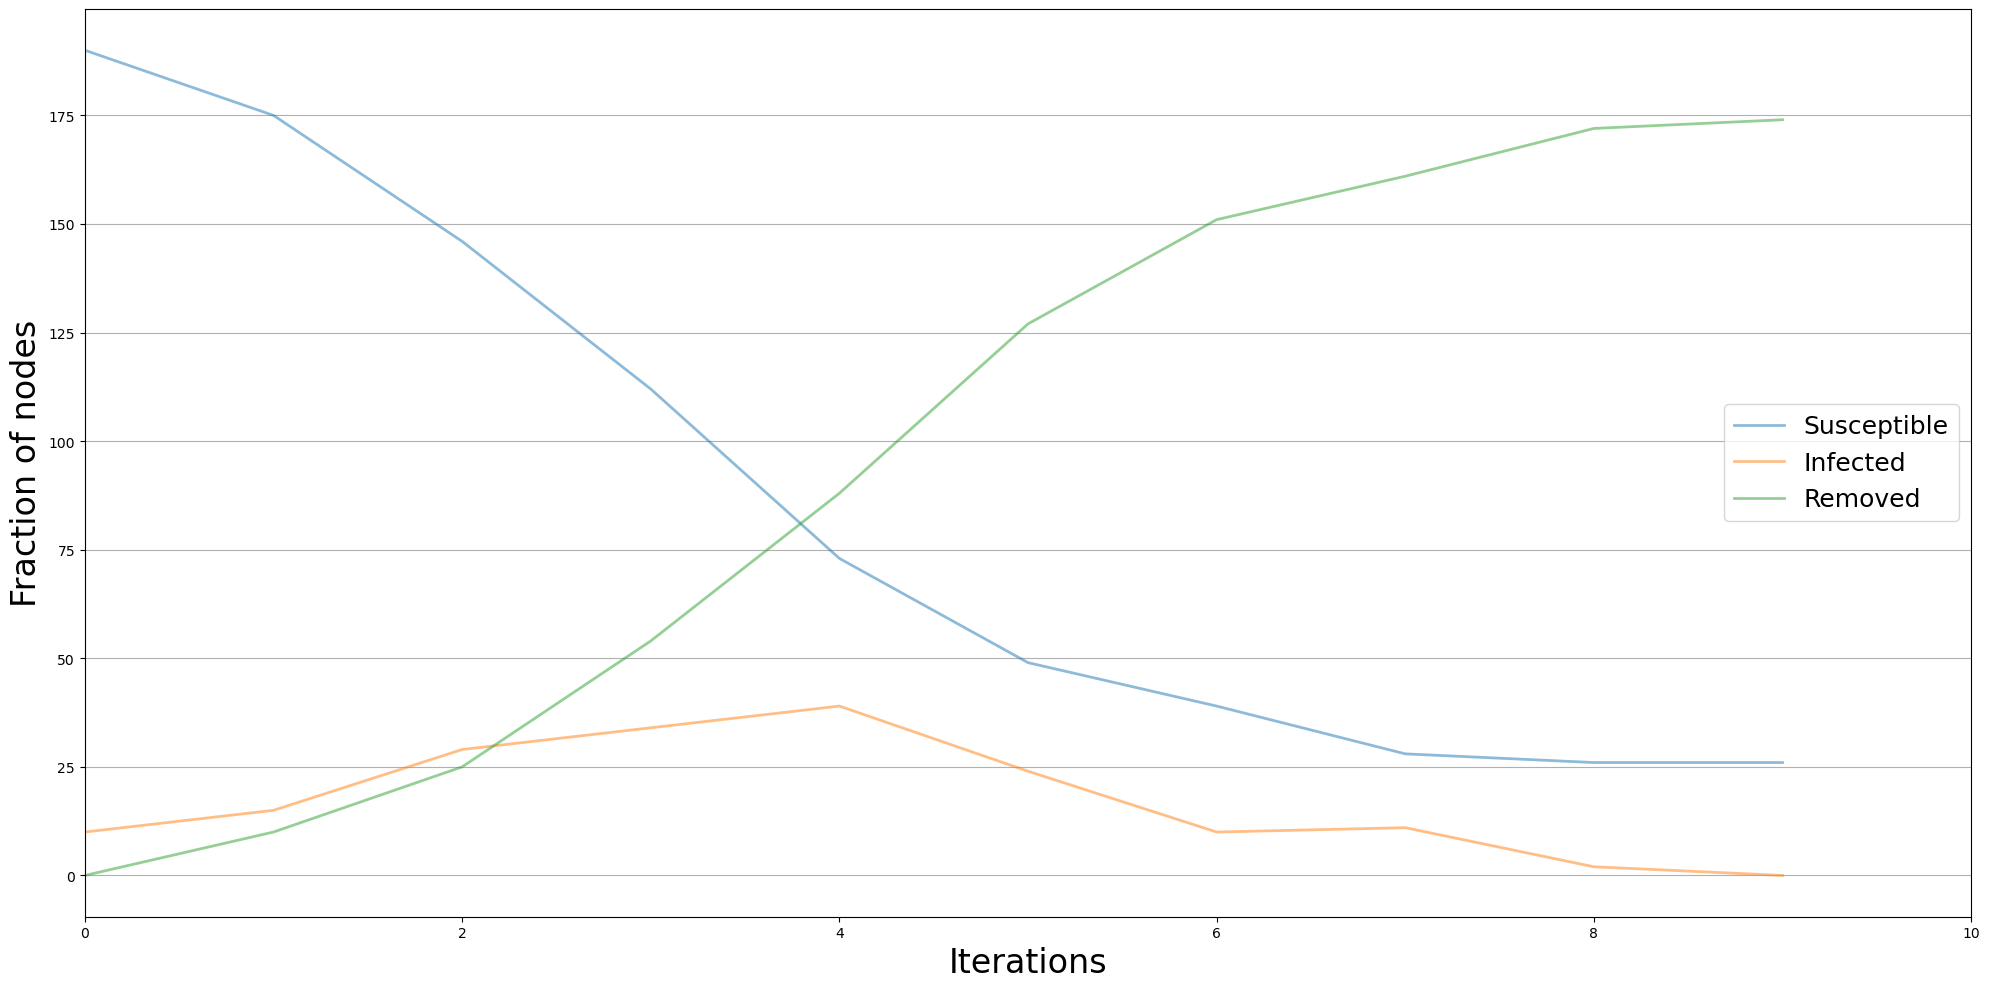

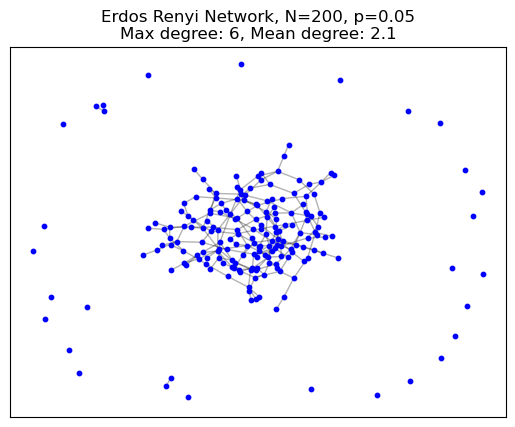

[{'trends': {'node_count': {0: [190, 154, 73, 20, 4, 1, 0, 0, 0, 0], 1: [10, 36, 81, 53, 16, 3, 1, 0, 0, 0], 2: [0, 10, 46, 127, 180, 196, 199, 200, 200, 200]}, 'status_delta': {0: [0, -36, -81, -53, -16, -3, -1, 0, 0, 0], 1: [0, 26, 45, -28, -37, -13, -2, -1, 0, 0], 2: [0, 10, 36, 81, 53, 16, 3, 1, 0, 0]}}}]


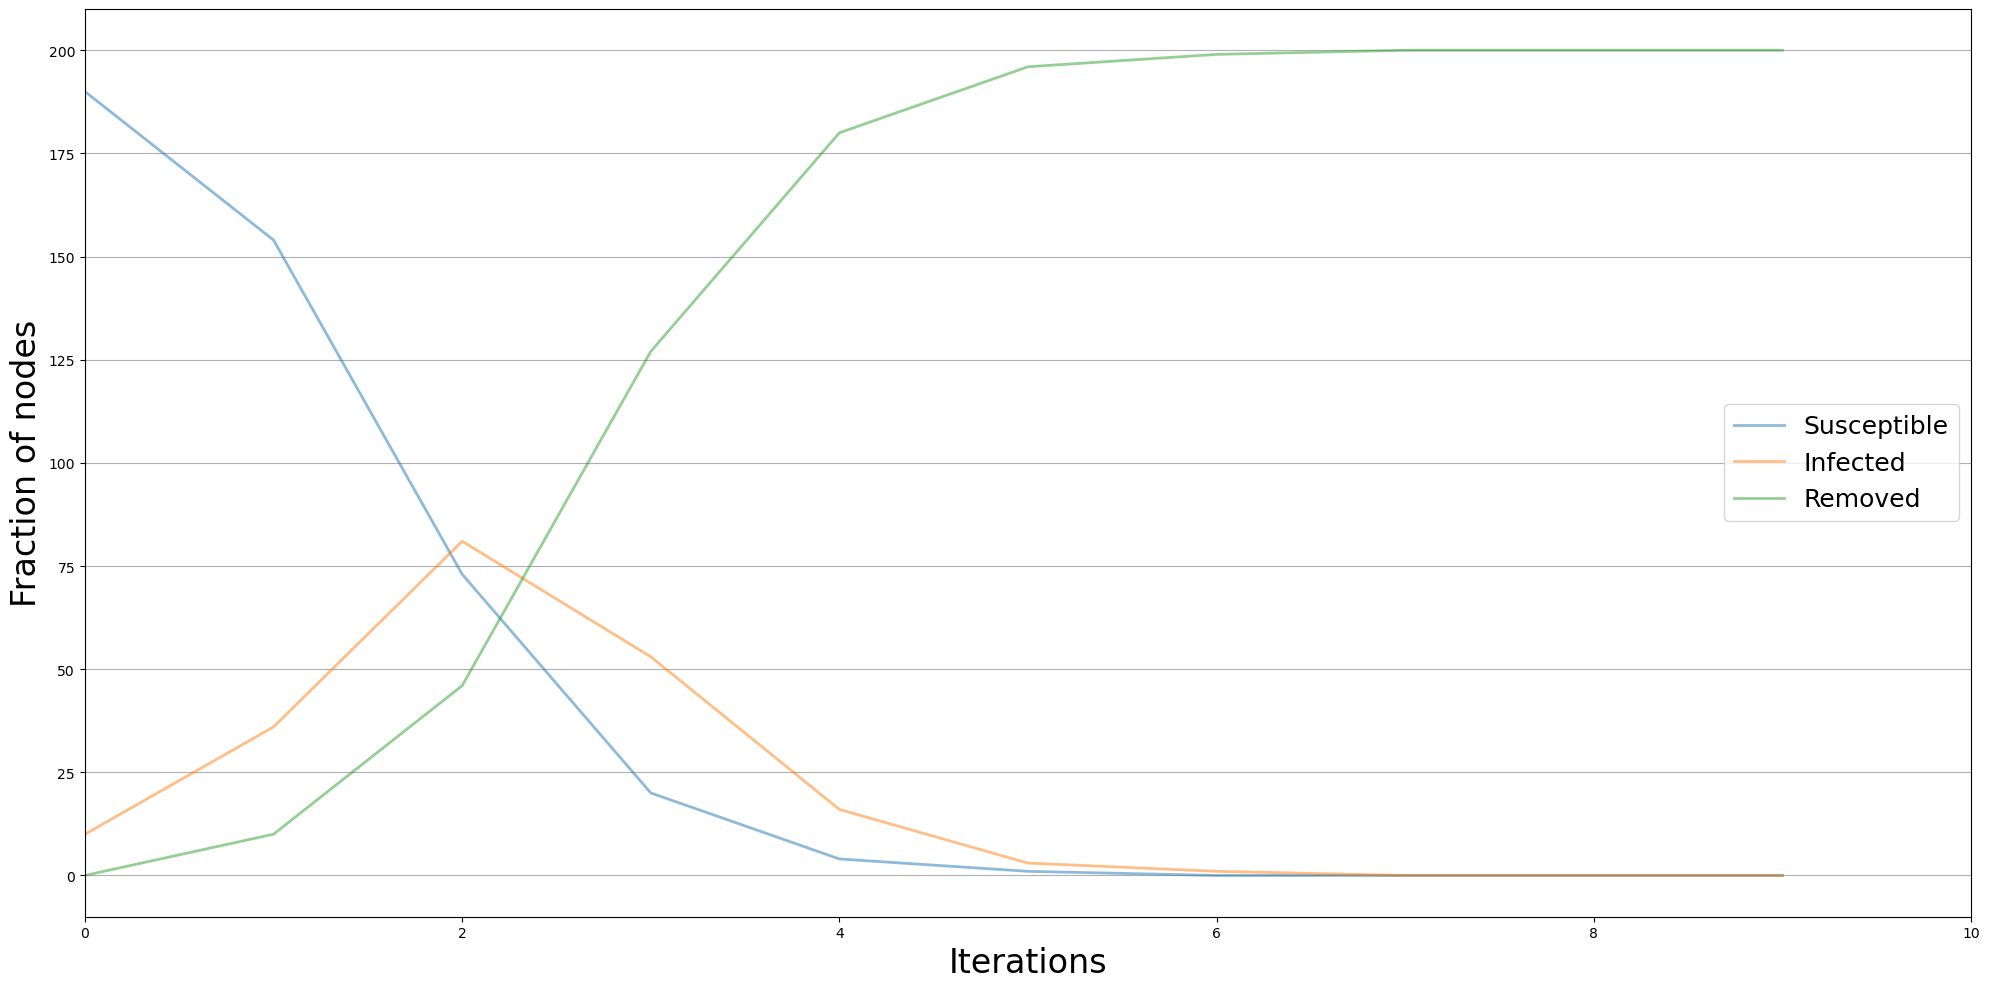

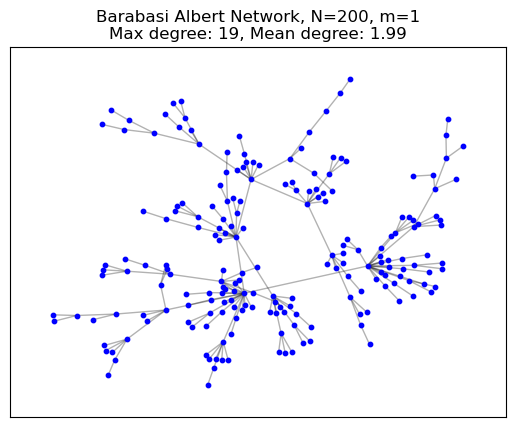

[{'trends': {'node_count': {0: [190, 155, 117, 70, 30, 11, 2, 0, 0, 0], 1: [10, 35, 38, 47, 40, 19, 9, 2, 0, 0], 2: [0, 10, 45, 83, 130, 170, 189, 198, 200, 200]}, 'status_delta': {0: [0, -35, -38, -47, -40, -19, -9, -2, 0, 0], 1: [0, 25, 3, 9, -7, -21, -10, -7, -2, 0], 2: [0, 10, 35, 38, 47, 40, 19, 9, 2, 0]}}}]


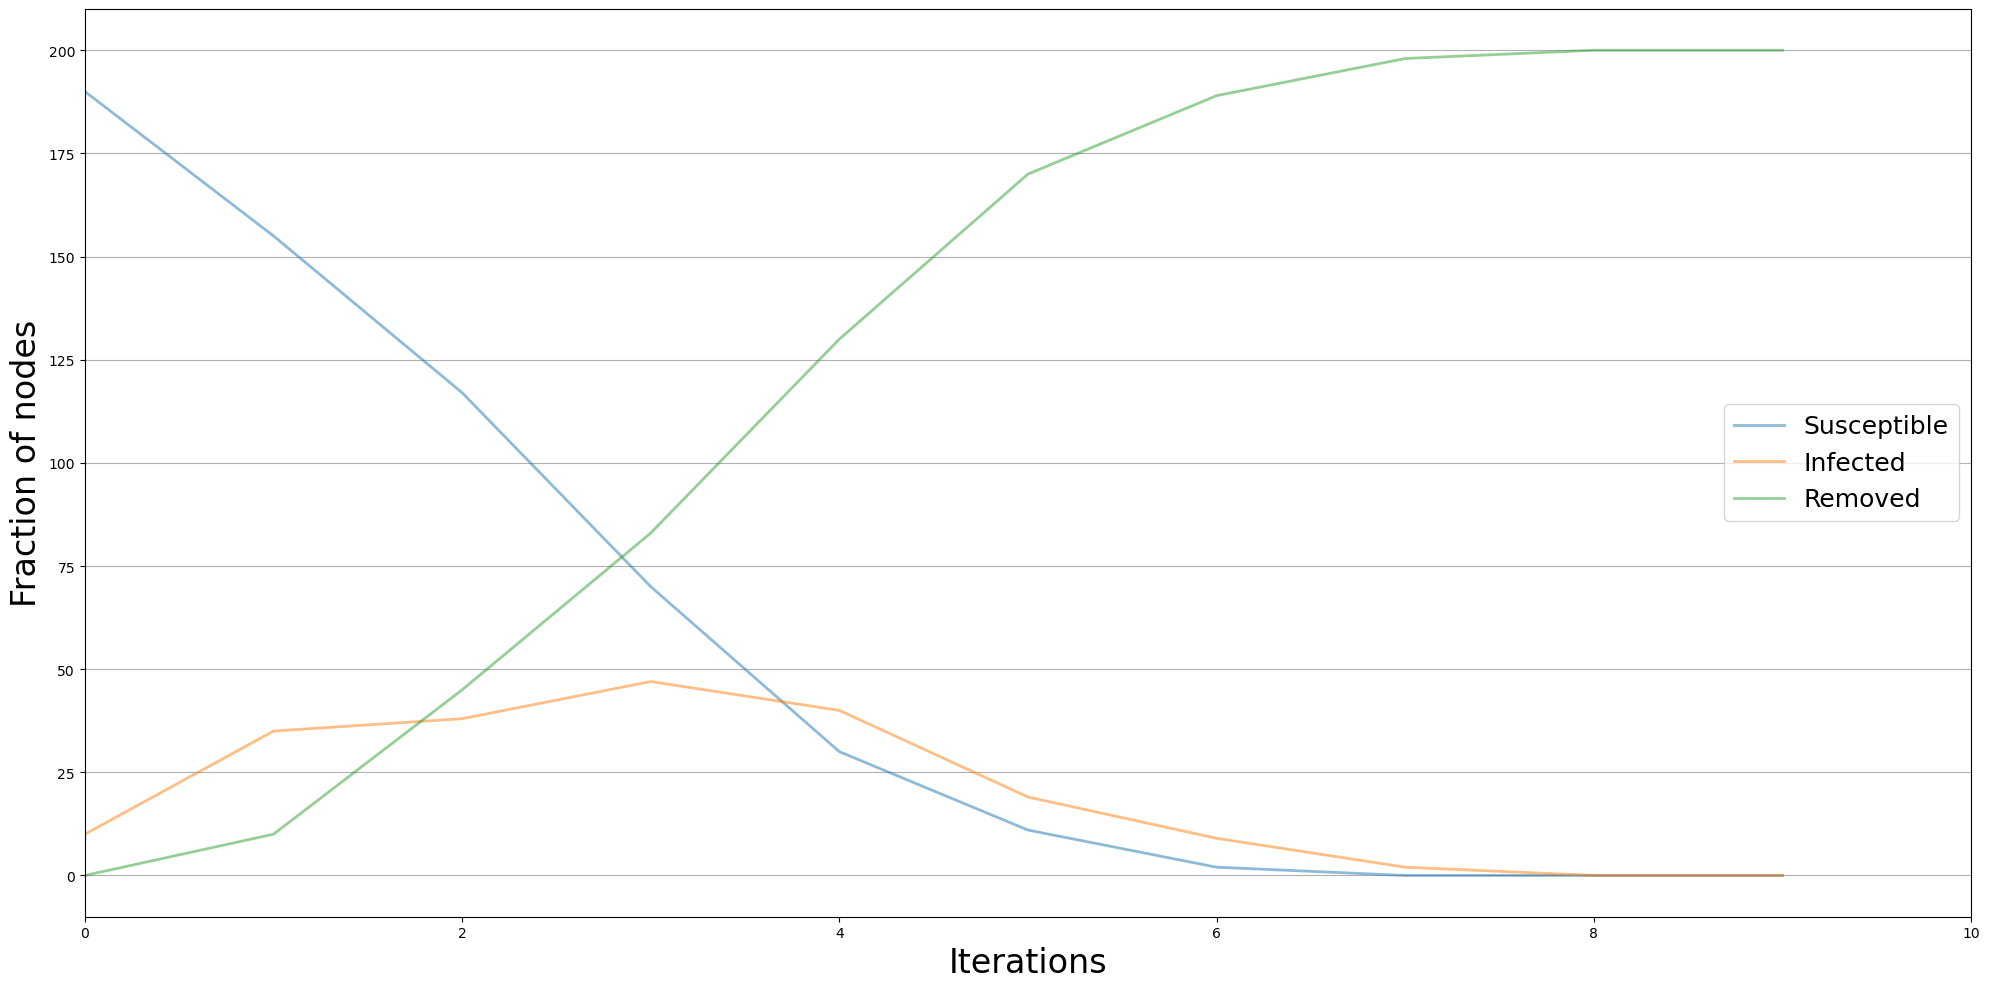

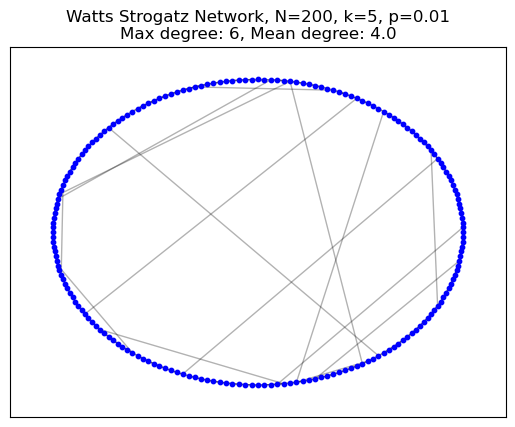

In [103]:
# Plot network topology for intuitive/qualitative understanding
# Erdos Renyi, Barabasi Albert, Watts Strogatz
%matplotlib inline
params = {
    'fraction_infected': 0.05,
    'beta': 5,
    'gamma': 1
}

# Erdos Renyi
g = nx.erdos_renyi_graph(200, 0.01) # N nodes, p chance for edge creation
simulate_network_sir(g,10,params,plot=True,title="Erdos Renyi")

pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, node_size=10, node_color="blue", alpha=1.0)
nx.draw_networkx_edges(g, pos, edge_color="black", alpha=0.3)
degrees = [d for n, d in g.degree()]
max_degree = max(degrees)
mean_degree = sum(degrees) / len(degrees)

plt.title("Erdos Renyi Network, N=200, p=0.05" + "\n" + "Max degree: " + str(round(max_degree,3)) + ", Mean degree: " + str(round(mean_degree,2)))
plt.show()

# Barabasi Albert
g = nx.barabasi_albert_graph(200,1) # N nodes, m edges from new node
simulate_network_sir(g,10,params,plot=True,title="Barabasi Albert")

pos = nx.spring_layout(g)
nx.draw_networkx_nodes(g, pos, node_size=10, node_color="blue", alpha=1.0)
nx.draw_networkx_edges(g, pos, edge_color="black", alpha=0.3)
degrees = [d for n, d in g.degree()]
max_degree = max(degrees)
mean_degree = sum(degrees) / len(degrees)

plt.title("Barabasi Albert Network, N=200, m=1" + "\n" + "Max degree: " + str(round(max_degree,3)) + ", Mean degree: " + str(round(mean_degree,2)))
plt.show()

# Watts Strogatz
g = nx.watts_strogatz_graph(200,5,0.05) # N nodes, k connected neighbours, p probability of rewiring each edge
simulate_network_sir(g,10,params,plot=True,title="Watts Strogatz")

pos = nx.shell_layout(g)
nx.draw_networkx_nodes(g, pos, node_size=10, node_color="blue", alpha=1.0)
nx.draw_networkx_edges(g, pos, edge_color="black", alpha=0.3)
degrees = [d for n, d in g.degree()]
max_degree = max(degrees)
mean_degree = sum(degrees) / len(degrees)
plt.title("Watts Strogatz Network, N=200, k=5, p=0.01" + "\n" + "Max degree: " + str(round(max_degree,3)) + ", Mean degree: " + str(round(mean_degree,2)))
plt.show()



In [114]:
import csv
import numpy as np
class graph_experiment:
    def __init__(self, type, nodes, parameter, times_run):
        self.times_run = times_run
        
        self.nodes = nodes
        self.type = type
        self.parameter = parameter
        
        self.mean_degree = np.zeros((times_run,len(nodes), len(parameter)))
        self.clustering = np.zeros((times_run,len(nodes), len(parameter)))
        self.diameter = np.zeros((times_run,len(nodes), len(parameter)))
        self.mean_inbetweenness = np.zeros((times_run,len(nodes), len(parameter)))
        self.mean_closeness = np.zeros((times_run,len(nodes), len(parameter)))

        self.mean_degree_std= np.zeros((len(nodes),len(parameter)))
        self.clustering_std= np.zeros((len(nodes), len(parameter)))
        self.diameter_std= np.zeros((len(nodes), len(parameter)))
        self.mean_inbetweenness_std= np.zeros((len(nodes), len(parameter)))
        self.mean_closeness_std= np.zeros((len(nodes), len(parameter)))

        self.avg_mean_degree = np.zeros((len(nodes), len(parameter)))
        self.avg_clustering = np.zeros((len(nodes), len(parameter)))
        self.avg_diameter = np.zeros((len(nodes), len(parameter)))
        self.avg_mean_inbetweenness = np.zeros((len(nodes), len(parameter)))
        self.avg_mean_closeness = np.zeros((len(nodes), len(parameter)))

    def calculate_stats(self):
        self.avg_mean_degree = np.mean(self.mean_degree,0)
        self.avg_clustering = np.mean(self.clustering,0)
        self.avg_diameter = np.mean(self.diameter,0)
        self.avg_mean_inbetweenness = np.mean(self.mean_inbetweenness,0)
        self.avg_mean_closeness = np.mean(self.mean_closeness,0)

        self.mean_degree_std= np.std(self.mean_degree,0)
        self.clustering_std= np.std(self.clustering,0)
        self.diameter_std= np.std(self.diameter,0)
        self.mean_inbetweenness_std= np.std(self.mean_inbetweenness,0)
        self.mean_closeness_std= np.std(self.mean_closeness,0)


    def save_to_csv(self, filename_prefix):
        header = np.zeros((1, len(self.parameter))) + self.times_run
        # Save results to CSV files
        separator = np.zeros(len(self.parameter))-1
        combined = np.vstack((header,
                              self.avg_mean_degree, 
                              separator, self.avg_clustering, 
                              separator, self.avg_diameter, 
                              separator, self.avg_mean_inbetweenness, 
                              separator, self.avg_mean_closeness,
                              separator, self.mean_degree_std, 
                              separator, self.clustering_std, 
                              separator, self.diameter_std, 
                              separator, self.mean_inbetweenness_std, 
                              separator, self.mean_closeness_std))
        # Save to CSV
        np.savetxt(f'{filename_prefix}.csv', combined, delimiter=';', fmt='%s')

    def read_from_csv(self, filename_prefix):
        data = np.loadtxt(f'{filename_prefix}.csv', delimiter=';')
        # Assuming the structure is known and fixed
        self.times_run = data[0,0]
        
        self.avg_mean_degree =   data[1:1+len(self.nodes)]
        self.avg_clustering =       data[2+len(self.nodes):2+2*len(self.nodes)]
        self.avg_diameter =         data[3+2*len(self.nodes):3+3*len(self.nodes)]
        self.avg_mean_inbetweenness=data[4+3*len(self.nodes):4+4*len(self.nodes)]
        self.avg_mean_closeness =   data[5+4*len(self.nodes):5+5*len(self.nodes)]

        self.mean_degree_std =   data[6+5*len(self.nodes):6+6*len(self.nodes)]
        self.clustering_std_std =   data[7+6*len(self.nodes):7+7*len(self.nodes)]
        self.diameter_std =         data[8+7*len(self.nodes):8+8*len(self.nodes)]
        self.mean_inbetweenness_std =    data[9+8*len(self.nodes):9+9*len(self.nodes)]
        self.mean_closeness_std =        data[10+9*len(self.nodes):10+10*len(self.nodes)]

    def combine_results(self, other):
        
        self.avg_mean_degree =   (other.avg_mean_degree*other.times_run + self.avg_mean_degree*self.times_run) / (self.times_run + other.times_run)
        self.avg_clustering =       (other.avg_clustering*other.times_run + self.avg_clustering*self.times_run) / (self.times_run + other.times_run)
        self.avg_diameter =         (other.avg_diameter*other.times_run + self.avg_diameter*self.times_run) / (self.times_run + other.times_run)
        self.avg_mean_inbetweenness=(other.avg_mean_inbetweenness*other.times_run + self.avg_mean_inbetweenness*self.times_run) / (self.times_run + other.times_run)
        self.avg_mean_closeness =   (other.avg_mean_closeness*other.times_run + self.avg_mean_closeness*self.times_run) / (self.times_run + other.times_run)
        
        self.mean_degree_std =       np.sqrt((np.square(self.mean_degree_std)*(self.times_run-1) + np.square(other.mean_degree_std)*(other.times_run-1))/(self.times_run+other.times_run-2))
        self.clustering_std =           np.sqrt((np.square(self.clustering_std)*(self.times_run-1) + np.square(other.clustering_std)*(other.times_run-1))/(self.times_run+other.times_run-2))
        self.diameter_std =             np.sqrt((np.square(self.diameter_std)*(self.times_run-1) + np.square(other.diameter_std)*(other.times_run-1))/(self.times_run+other.times_run-2))
        self.mean_inbetweenness_std =   np.sqrt((np.square(self.mean_inbetweenness_std)*(self.times_run-1) + np.square(other.mean_inbetweenness_std)*(other.times_run-1))/(self.times_run+other.times_run-2))
        self.mean_closeness_std =       np.sqrt((np.square(self.mean_closeness_std)*(self.times_run-1) + np.square(other.mean_closeness_std)*(other.times_run-1))/(self.times_run+other.times_run-2))

        self.times_run += other.times_run
        print("Done")
        
def plot_heatmaps(mean_degree, clustering, ns, ps,type):
    # Plot heatmaps
    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{type} Network Properties")
    plt.subplot(1, 2, 1)
    sns.heatmap(mean_degree, xticklabels=np.round(ps, 2), yticklabels=np.round(ns, 0), cmap="YlGnBu")
    plt.title("Median Degree")
    if type == 'barabasi_albert':
        plt.xlabel("Number of edges m")
        plt.ylabel("Number of Nodes n")
    elif type == 'watts_strogatz':
        plt.xlabel("Probability p")
        plt.ylabel("Number of connected neighbours k")
    elif type == 'erdos_renyi':
        plt.xlabel("Probability p")
        plt.ylabel("Number of Nodes n")

    plt.subplot(1, 2, 2)
    sns.heatmap(clustering, xticklabels=np.round(ps, 2), yticklabels=np.round(ns, 0), cmap="YlGnBu")
    plt.title("Clustering Coefficient")
    if type == 'barabasi_albert':
        plt.xlabel("Number of edges m")
        plt.ylabel("Number of Nodes n")
    elif type == 'watts_strogatz':
        plt.xlabel("Probability p")
        plt.ylabel("Number of connected neighbours k")
    elif type == 'erdos_renyi':
        plt.xlabel("Probability p")
        plt.ylabel("Number of Nodes n")
    plt.show()


def graph_exploration(type,A, B, N):

    result = graph_experiment(type, A, B, N)

    for n in range(N):
        print("computing {}, {}".format(type,n))
        for i, a in enumerate(A):
            print("N={}".format(a))
            for j, b in enumerate(B):
                if type == 'erdos_renyi':
                    g = nx.erdos_renyi_graph(int(a),b)
                elif type == 'barabasi_albert':
                    g = nx.barabasi_albert_graph(int(a), int(b))
                elif type == 'watts_strogatz':
                    g = nx.watts_strogatz_graph(int(a), 5, b)
                else:
                    raise ValueError("Unknown graph type")
                
                degrees = [d for n, d in g.degree()]
                result.mean_degree[n, i, j] = np.sum(degrees) / len(degrees)
                result.clustering[n, i, j] = nx.average_clustering(g)
                result.mean_inbetweenness[n, i, j] = np.mean(list(nx.betweenness_centrality(g).values()))
                result.mean_closeness[n, i, j] = np.mean(list(nx.closeness_centrality(g).values()))

                if type != 'erdos_renyi':
                    result.diameter[n, i, j] += nx.diameter(g)
                else:
                    Gcc = sorted(nx.connected_components(g), key=len, reverse=True)
                    G0 = g.subgraph(Gcc[0])
                    result.diameter[n,i, j] += nx.diameter(G0)
    result.calculate_stats()
    return result

def plot_graph_exploration(result):
    plt.figure(figsize=(15, 10))
    plt.subplot(2,3,1)
    if result.type == 'barabasi_albert':
        param_name='m'
    else:
        param_name='p'

    for i, a in enumerate(result.parameter):
        plt.plot(result.nodes,result.avg_mean_degree[:,i], label=f"{param_name}={a}")
        plt.fill_between(result.nodes, result.avg_mean_degree[:,i]-result.mean_degree_std[:,i], result.avg_mean_degree[:,i]+result.mean_degree_std[:,i], color='b', alpha=0.2)
    plt.xlabel("Number of Nodes n")
    plt.ylabel("Mean Degree")
    plt.title("Mean Degree")
    plt.legend(loc='center right')

    plt.subplot(2,3,2)
    for i, a in enumerate(result.parameter):
        plt.plot(result.nodes,result.avg_clustering[:,i], label=f"{param_name}={a}")
        plt.fill_between(result.nodes, result.avg_clustering[:,i]-result.clustering_std[:,i], result.avg_clustering[:,i]+result.clustering_std[:,i], color='b', alpha=0.2)

    plt.xlabel("Number of Nodes n")
    plt.ylabel("Average Clustering")
    plt.title("Average clustering")
    plt.legend(loc='center right')

    plt.subplot(2,3,3)
    for i, a in enumerate(result.parameter):
        plt.plot(result.nodes,result.avg_diameter[:,i], label=f"{param_name}={a}")
        plt.fill_between(result.nodes, result.avg_diameter[:,i]-result.diameter_std[:,i], result.avg_diameter[:,i]+result.diameter_std[:,i], color='b', alpha=0.2)

    plt.xlabel("Number of Nodes n")
    plt.ylabel("Network Diameter")
    plt.title("Diameter of the giant compartment")
    plt.legend(loc='center right')

    plt.subplot(2,3,4)
    for i, a in enumerate(result.parameter):
        plt.plot(result.nodes,result.avg_mean_inbetweenness[:,i], label=f"{param_name}={a}")
        plt.fill_between(result.nodes, result.avg_mean_inbetweenness[:,i]-result.mean_inbetweenness_std[:,i], result.avg_mean_inbetweenness[:,i]+result.mean_inbetweenness_std[:,i], color='b', alpha=0.2)

    plt.xlabel("Number of Nodes n")
    plt.ylabel("Mean In-Betweenness")
    plt.title("Mean In-Betweenness")
    plt.legend(loc='center right')

    plt.subplot(2,3,5)
    for i, a in enumerate(result.parameter):
        plt.plot(result.nodes,result.avg_mean_closeness[:,i], label=f"{param_name}={a}")
        plt.fill_between(result.nodes, result.avg_mean_closeness[:,i]-result.mean_closeness_std[:,i], result.avg_mean_closeness[:,i]+result.mean_closeness_std[:,i], color='b', alpha=0.2)

    plt.xlabel("Number of Nodes n")
    plt.ylabel("Mean Closeness")
    plt.title("Mean Closeness")
    plt.legend(loc='center right')

    plt.tight_layout()
    plt.suptitle("{} Network Properties, runs={}".format(result.type,result.times_run), y=1.02)
    plt.show()


In [ ]:

N = 2
# Erdos renyi params
ns_er = np.linspace(100, 500, 5,dtype=int)
ps_er = [0.001,0.01,0.1,0.5]

# Barabasi Albert params
ns_ba = np.linspace(100, 500, 5,dtype=int)
ms_ba = [1,2,4,8]

# Watts Strogatz params
ns_ws = np.linspace(100, 500, 5,dtype=int)
ps_ws = [0.001, 0.01, 0.1, 0.5]

computing barabasi_albert, 0
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 1
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 2
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 3
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 4
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 5
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 6
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 7
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 8
N=100
N=200
N=300
N=400
N=500
computing barabasi_albert, 9
N=100
N=200
N=300
N=400
N=500


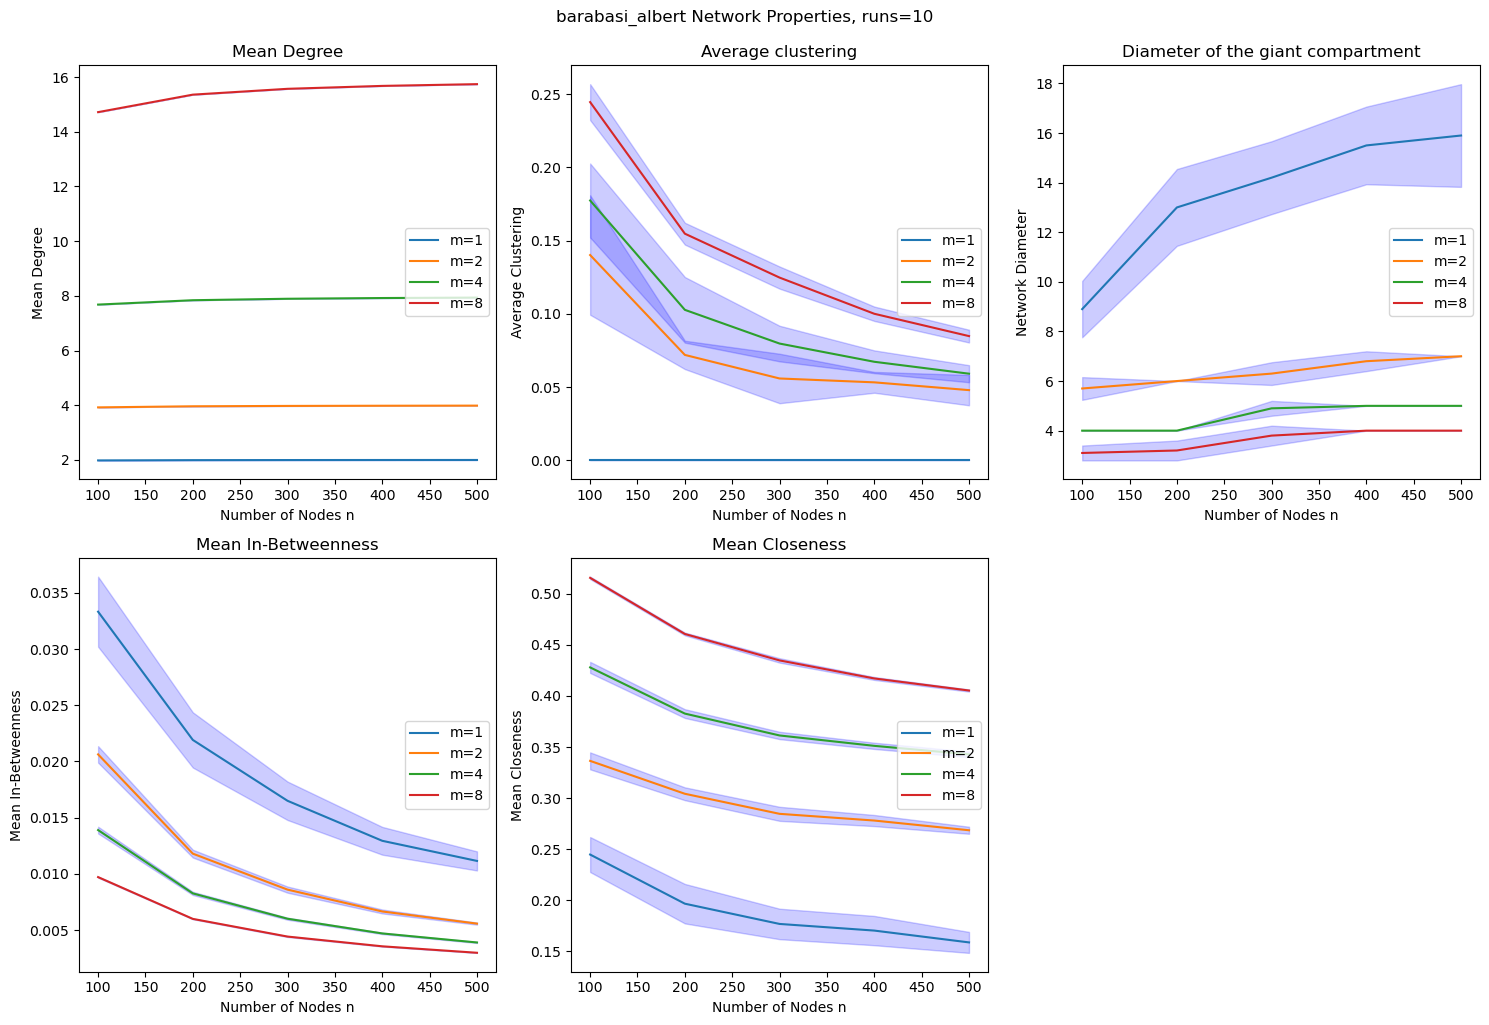

In [115]:
result_ba = graph_exploration('barabasi_albert',ns_ba,ms_ba,10)
result_ba.save_to_csv('barabasi_albert')
# for m in range(0,4):
#     print(f"M={m}")
#     new_results_ba = graph_exploration('barabasi_albert',ns_ba,ms_ba,10)
#     old_results_ba = graph_experiment('barabasi_albert',ns_ba,ms_ba,0)
#     old_results_ba.read_from_csv('barabasi_albert')
#     new_results_ba.combine_results(old_results_ba)
#     new_results_ba.save_to_csv('barabasi_albert')

plot_graph_exploration(result_ba)

computing watts_strogatz, 0
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 1
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 2
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 3
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 4
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 5
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 6
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 7
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 8
N=100
N=200
N=300
N=400
N=500
computing watts_strogatz, 9
N=100
N=200
N=300
N=400
N=500


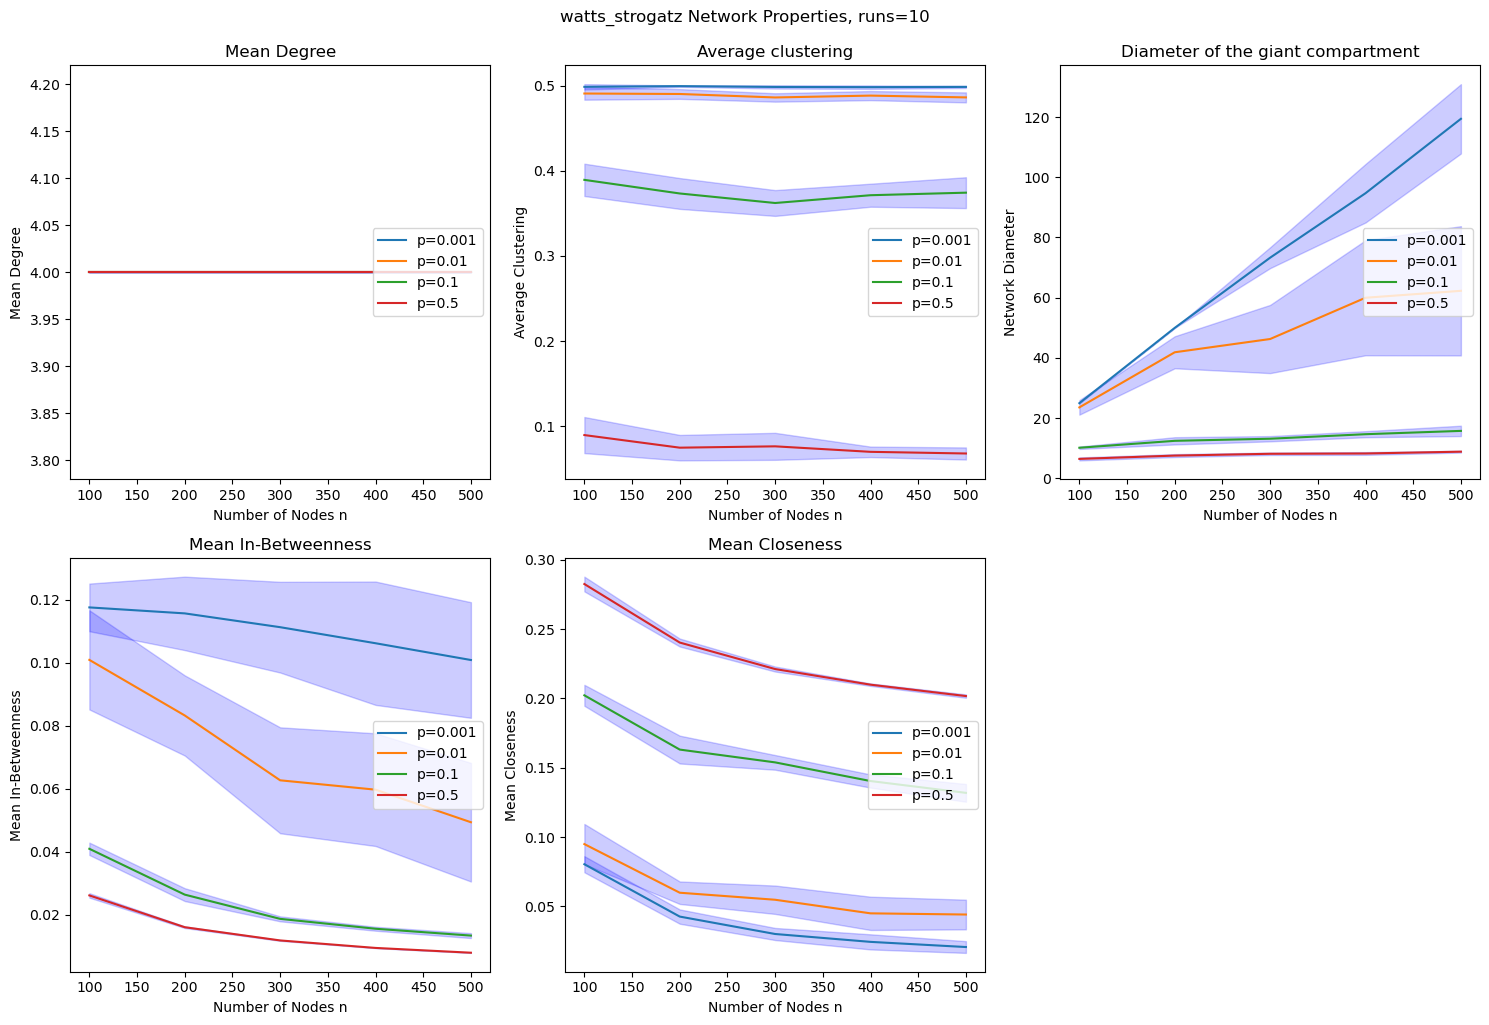

In [120]:
result_ws = graph_exploration('watts_strogatz',ns_ws,ps_ws,10)
result_ws.save_to_csv('watts_strogatz')
# for m in range(0,4):
#     print(f"M={m}")
#     new_results_ws = graph_exploration('watts_strogatz',ns_ws,ps_ws,10)
#     old_results_ws = graph_experiment('watts_strogatz',ns_ws,ps_ws,0)
#     old_results_ws.read_from_csv('watts_strogatz')
#     new_results_ws.combine_results(old_results_ws)
#     new_results_ws.save_to_csv('watts_strogatz')

plot_graph_exploration(result_ws)

computing erdos_renyi, 0
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 1
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 2
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 3
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 4
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 5
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 6
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 7
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 8
N=100
N=200
N=300
N=400
N=500
computing erdos_renyi, 9
N=100
N=200
N=300
N=400
N=500


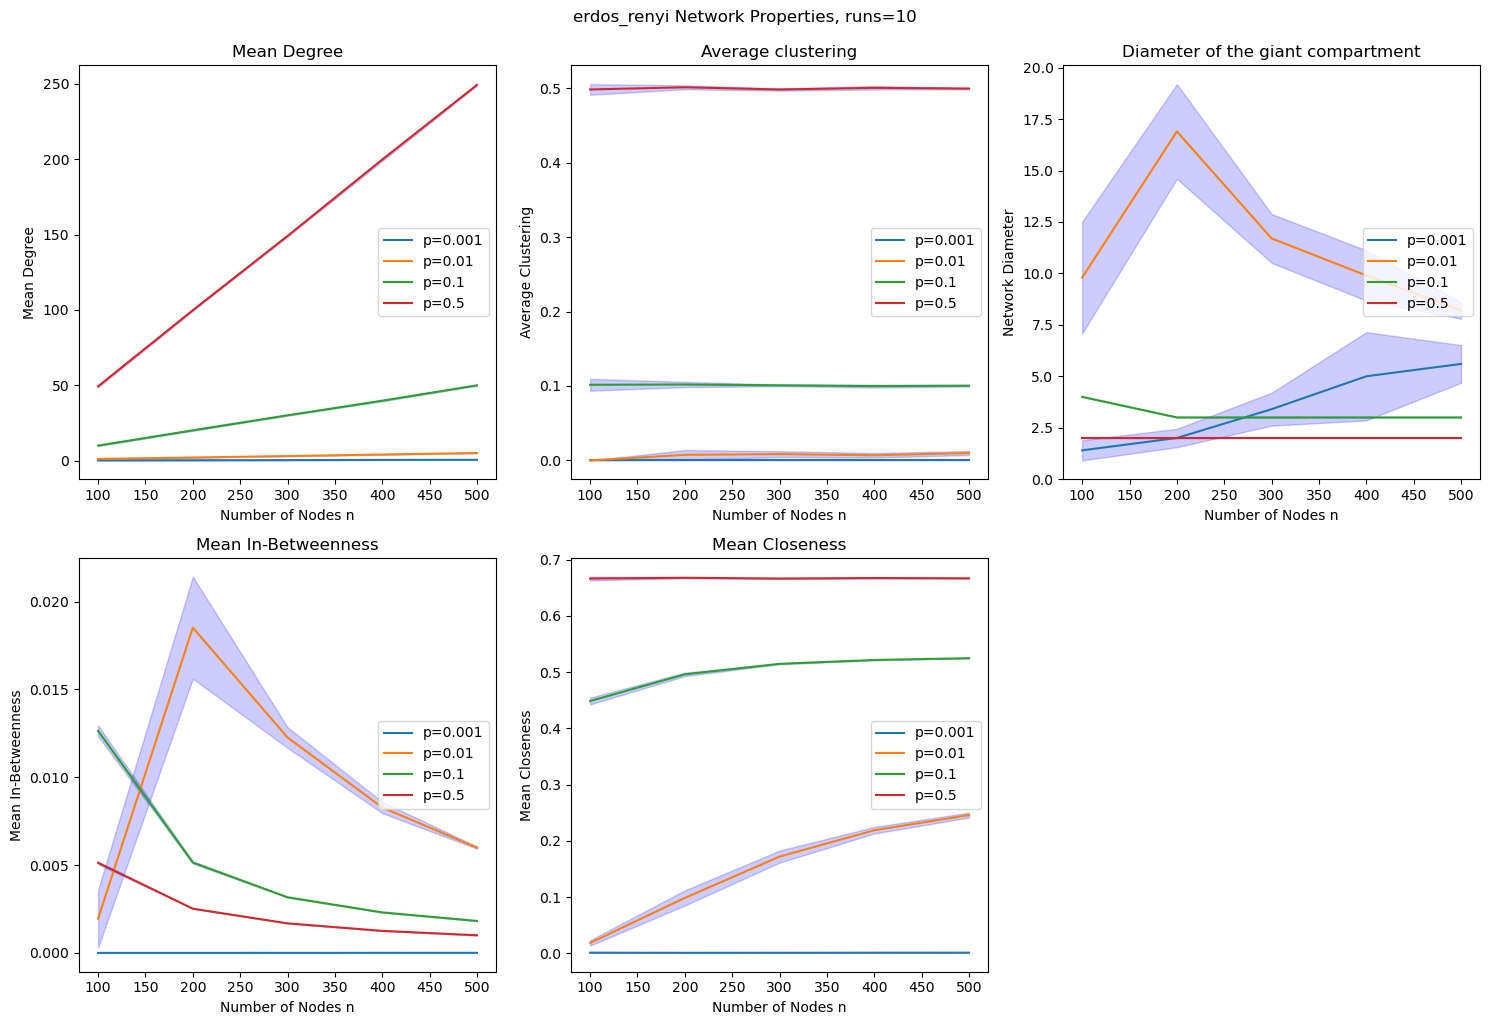

In [117]:
result_er = graph_exploration('erdos_renyi',ns_er,ps_er,10)
result_er.save_to_csv('erdos_renyi')
# for m in range(0,1):
#     print(f"M={m}")
#     new_results_er = graph_exploration('erdos_renyi',ns_er,ps_er,7)
#     old_results_er = graph_experiment('erdos_renyi',ns_er,ps_er,0)
#     old_results_er.read_from_csv('erdos_renyi')
#     new_results_er.combine_results(old_results_er)
#     new_results_er.save_to_csv('erdos_renyi')

plot_graph_exploration(result_er)

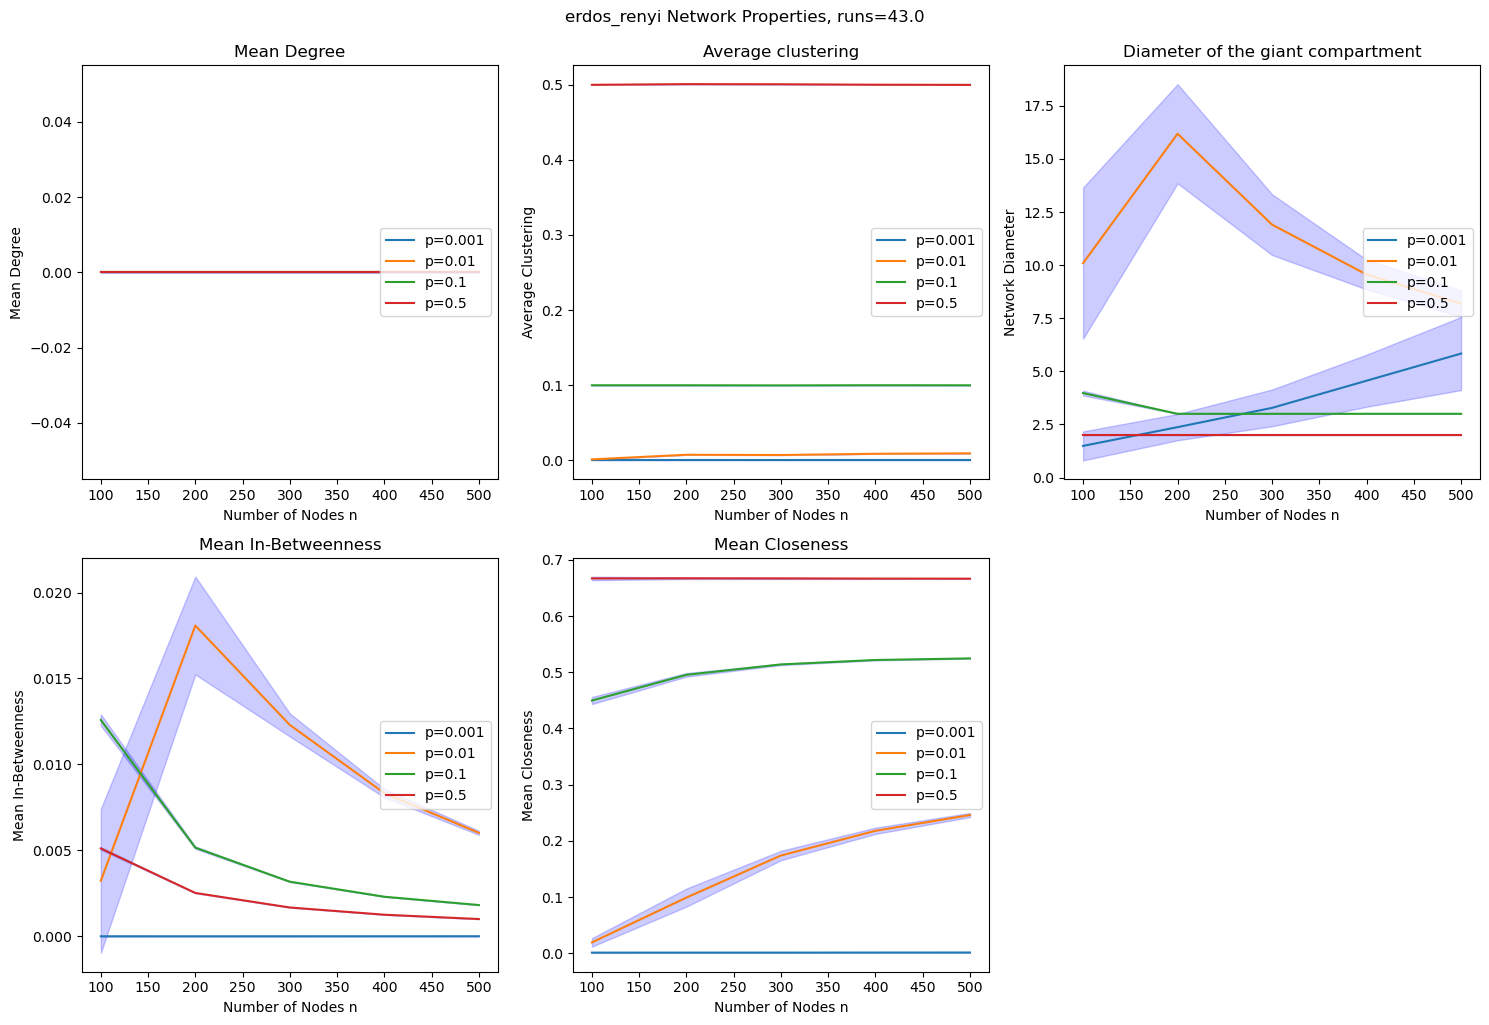

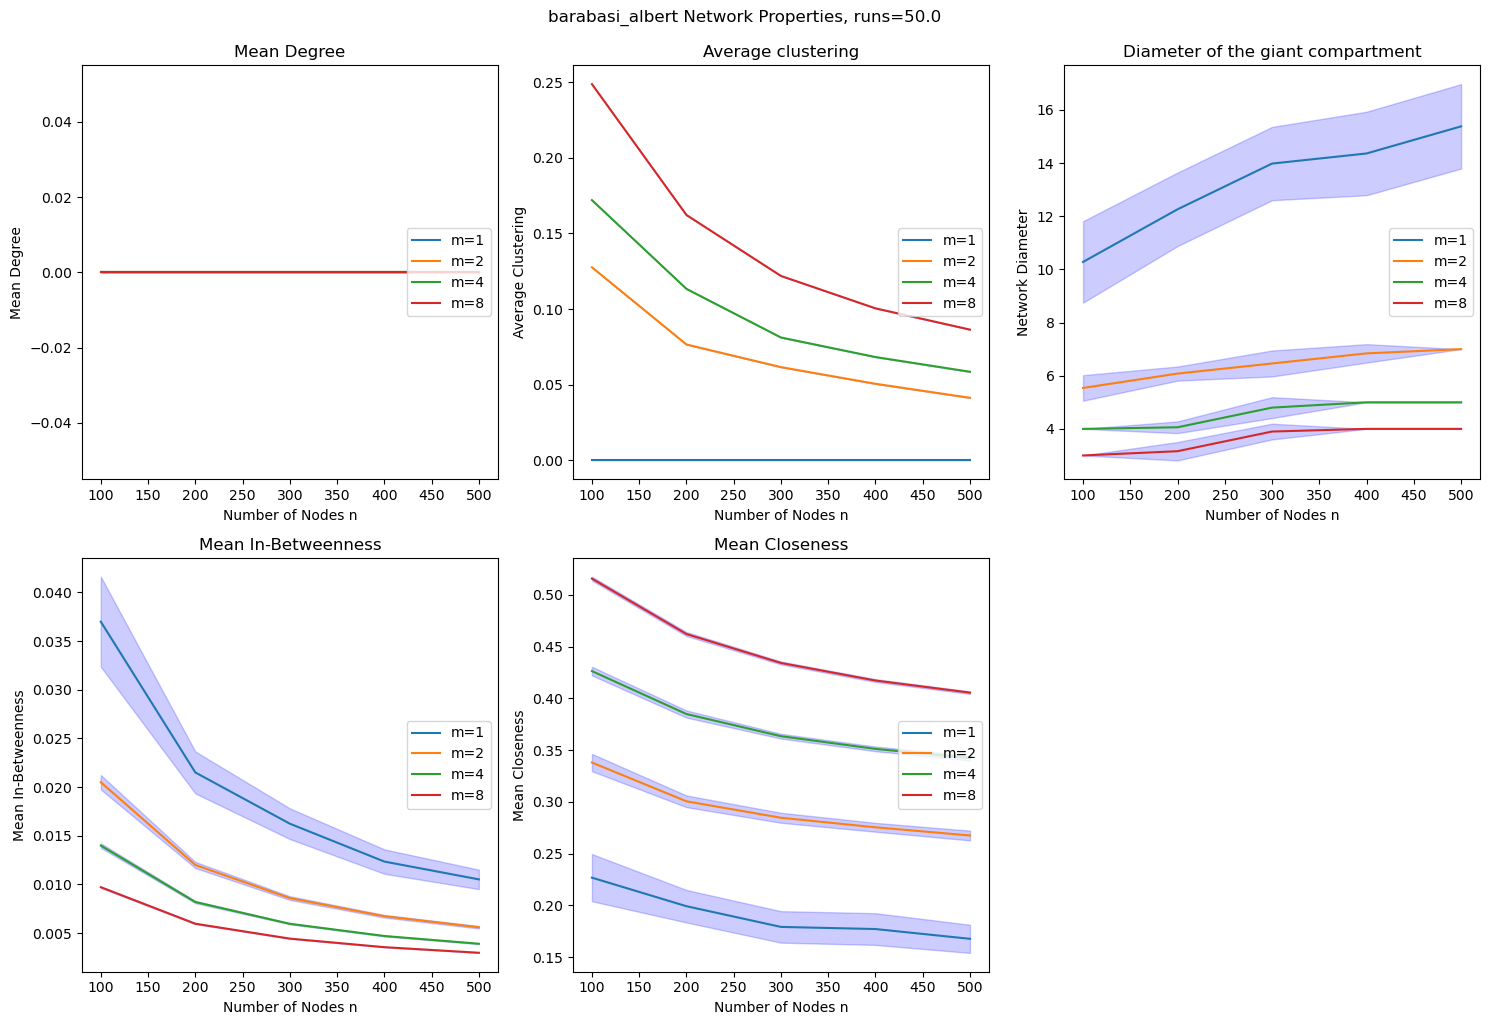

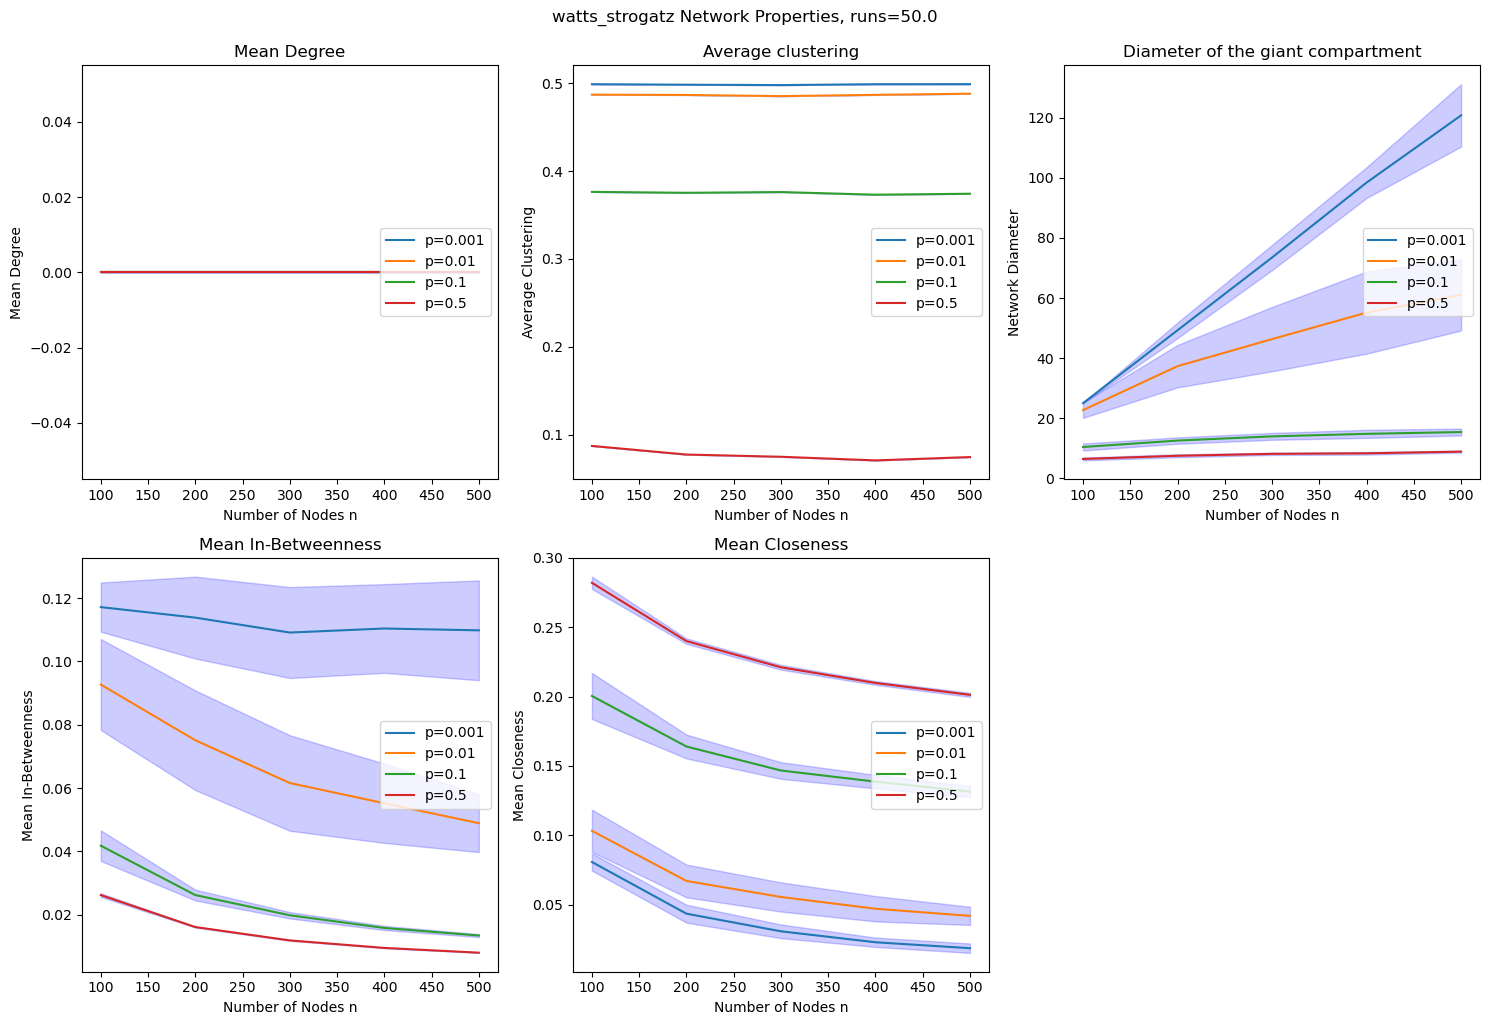

In [106]:
result_er = graph_experiment('erdos_renyi',ns_er,ps_er,0)
result_ba = graph_experiment('barabasi_albert',ns_ba,ms_ba,0)
result_ws = graph_experiment('watts_strogatz',ns_ws,ps_ws,0)

result_er.read_from_csv('erdos_renyi')
result_ba.read_from_csv('barabasi_albert')
result_ws.read_from_csv('watts_strogatz')

plot_graph_exploration(result_er)
plot_graph_exploration(result_ba)
plot_graph_exploration(result_ws)


computing for beta=0.01
computing for beta=0.02
computing for beta=0.03
computing for beta=0.04


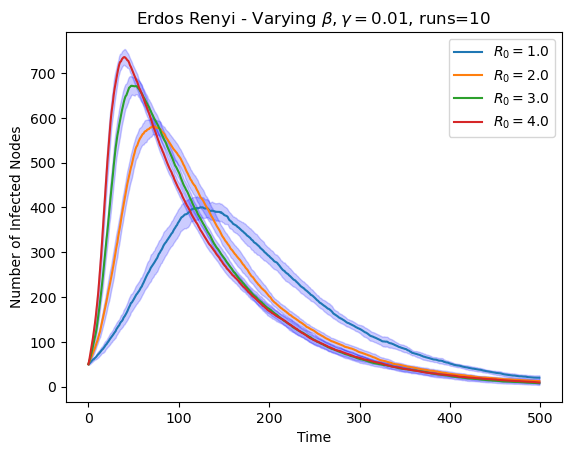

computing for beta=0.01
computing for beta=0.02
computing for beta=0.03
computing for beta=0.04


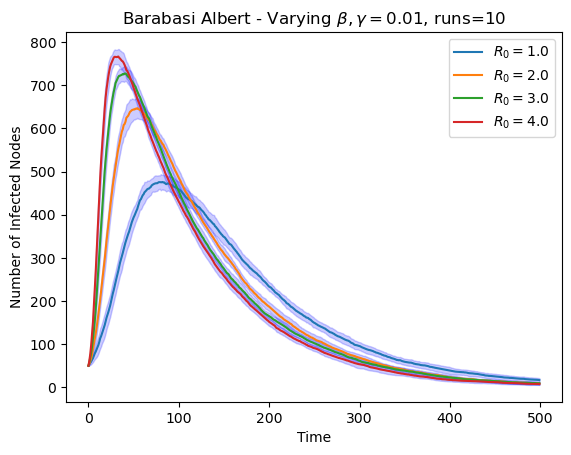

computing for beta=0.01
computing for beta=0.02
computing for beta=0.03
computing for beta=0.04


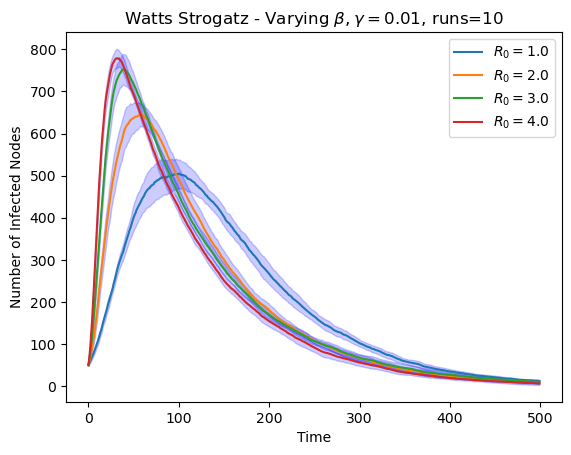

In [48]:
# Experiment with parameters (beta, gamma, fraction_infected) on given network type
%matplotlib inline
def experiment_parameters(graphtype, params, max_time, param_name, param_values, title_prefix,runs):
    for value in param_values:
        params[param_name] = value
        R0 = value/params['gamma']
        print(f"computing for beta={value}")
        trends_list = []
        for i in range(runs):
            if graphtype=='er':
                graph = nx.erdos_renyi_graph(1000, 0.005) # N nodes, p chance for edge creation
            elif graphtype =='ba':
                graph = nx.barabasi_albert_graph(1000,3) # N nodes, m edges from new node
            elif graphtype =='ws':
                graph = nx.watts_strogatz_graph(1000,10,0.01) # N nodes, k connected neighbours, p probability of rewiring each edge

            data = simulate_network_sir(graph,max_time,params,return_trends=True)
            trends = data[0]['trends']['node_count'][1]
            trends_list.append(trends)
        avg_trends = np.mean(np.array(trends_list),axis=0)
        std_trends = np.std(np.array(trends_list),axis=0)
        # Plotting the trends

        plt.plot(range(len(avg_trends)), avg_trends, label=rf"$R_0={round(R0,2)}$")
        plt.fill_between(range(len(avg_trends)), avg_trends-std_trends, avg_trends+std_trends, color='b', alpha=0.2)

    plt.xlabel("Time")
    plt.ylabel("Number of Infected Nodes")
    plt.title(rf"{title_prefix} - Varying $\beta,\gamma={params['gamma']}$, runs={runs}")
    plt.legend()
    plt.show()

# Example usage:
params['beta'] = 0.01  # Reset to default
params['gamma'] = 0.01  # Reset to default
params['fraction_infected'] = 0.05  # Reset to default  

experiment_parameters('er', params, 500, 'beta', [0.01, 0.02, 0.03, 0.04], "Erdos Renyi",10)

experiment_parameters('ba', params, 500, 'beta', [0.01, 0.02, 0.03, 0.04], "Barabasi Albert",10)

experiment_parameters('ws', params, 500, 'beta', [0.01, 0.02, 0.03, 0.04], "Watts Strogatz",10)
        

In [162]:
params['beta'] = 0.02  # Reset to default
params['gamma'] = 0.01  # Reset to default
params['fraction_infected'] = 0.05  # Reset to default  


def compare_graphtypes(graphtypes,runs,gs=None):
    if gs:
        for g,graphtype in gs:
            print(f"computing for graph type={graphtype}")
            trends_list=[]
            for i in range(runs):
                trends = simulate_network_sir(g,150,params,return_trends=True)[0]['trends']['node_count'][1]
                trends_list.append(trends)
            avg_trends = np.mean(np.array(trends_list),axis=0)
            std_trends = np.std(np.array(trends_list),axis=0)
            plt.plot(range(len(avg_trends)),avg_trends,label=graphtype)
            plt.fill_between(range(len(avg_trends)),avg_trends-std_trends,avg_trends+std_trends,color='b',alpha=0.1)
    if not gs:
        for graphtype in graphtypes:
            print(f"computing for graph type={graphtype}")
            trends_list=[]
            for i in range(runs):
                if graphtype=='er':
                    graph = nx.erdos_renyi_graph(250, 0.005) # N nodes, p chance for edge creation
                elif graphtype =='ba':
                    graph = nx.barabasi_albert_graph(1000,3) # N nodes, m edges from new node
                elif graphtype =='ws':
                    graph = nx.watts_strogatz_graph(1000,10,0.01) # N nodes, k connected neighbours, p probability of rewiring each edge
                
                trends = simulate_network_sir(graph,400,params,return_trends=True)[0]['trends']['node_count'][1]
                trends_list.append(trends)
            avg_trends = np.mean(np.array(trends_list),axis=0)
            std_trends = np.std(np.array(trends_list),axis=0)
            plt.plot(range(len(avg_trends)),avg_trends,label=graphtype)
            plt.fill_between(range(len(avg_trends)),avg_trends-std_trends,avg_trends+std_trends,color='b',alpha=0.2)
    plt.xlabel('Time')
    plt.ylabel('Infected Nodes')
    plt.title(rf'Comparison between graph types, $R_0={params['beta']/params['gamma']}$,runs={runs}')
    plt.legend()
    plt.show()



In [10]:
# Connection probability


# Load Socipatterns data

Loaded graph with 375 nodes and 1639 edges


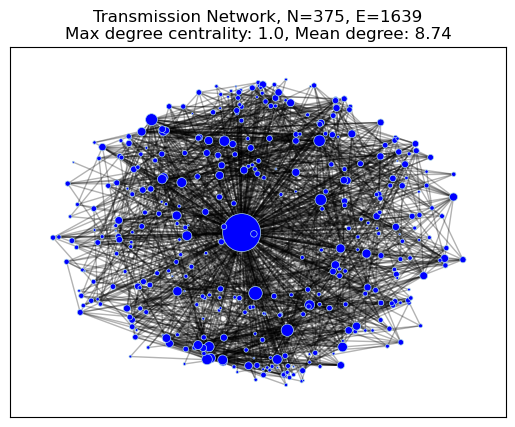

<Figure size 500x500 with 0 Axes>

(375,1639)
Average Degree:  8.741333333333333
Average Clustering Coefficient:  0.5555319463686345
Diameter:  2
Mean In-Betweenness:  0.0026183041581243753
Mean Closeness:  0.5066033489568377


In [155]:
%matplotlib inline
# g = nx.read_edgelist("data/transmission_network.csv", delimiter=";", create_using=nx.Graph(),data=False)
g_array = np.loadtxt("data/transmission_network.csv",delimiter=";")
g = nx.from_numpy_array(g_array)
print("Loaded graph with {} nodes and {} edges".format(g.number_of_nodes(), g.number_of_edges()))

# Show graph info
# pos = nx.kamada_kawai_layout(g)
# pos = nx.planar_layout(g)
pos = nx.spring_layout(g)

degrees = g.degree()
node_sizes = [degrees[n] * 2 for n in g.nodes()]  # Scale by 10 for visibility

nx.draw_networkx_nodes(g, pos, node_size=node_sizes, linewidths=0.5, edgecolors='lightblue', node_color="blue", alpha=1.0)
nx.draw_networkx_edges(g, pos, edge_color="black", alpha=0.3)
centrality = nx.degree_centrality(g)
degrees = [d for n, d in g.degree()]
mean_degree = sum(degrees) / len(degrees)

plt.title("Transmission Network, N={}, E={}".format(g.number_of_nodes(), g.number_of_edges()) 
          + "\n" 
          + f"Max degree centrality: {round(max(centrality.values()),3)}" 
          + f", Mean degree: {round(mean_degree,2)}")

plt.figure(figsize=(5,5))
plt.show()

def compute_graph_metrics(g):
    nodes = g.number_of_nodes()
    edges = g.number_of_edges()
    degrees = [d for n, d in g.degree()]
    avg_degree = sum(degrees) / len(degrees)
    avg_clustering = nx.average_clustering(g)
    diameter = nx.diameter(g)
    mean_inbetweenness = np.mean(list(nx.betweenness_centrality(g).values()))
    mean_closeness = np.mean(list(nx.closeness_centrality(g).values()))

    print(f"({nodes},{edges})")
    print("Average Degree: ", avg_degree)
    print("Average Clustering Coefficient: ", avg_clustering)
    print("Diameter: ", diameter)
    print("Mean In-Betweenness: ", mean_inbetweenness)
    print("Mean Closeness: ", mean_closeness)

compute_graph_metrics(g)

In [140]:
# try to approximate sociopatterns network with erdos renyi
N = g.number_of_nodes()
E = g.number_of_edges()
p = (2 * E) / (N * (N - 1))
print("Approximated Erdos Renyi p: ", p)
print()
er_g = nx.erdos_renyi_graph(N,p)
compute_graph_metrics(er_g)


Approximated Erdos Renyi p:  0.023372549019607843

(375,1615)
Average Degree:  8.613333333333333
Average Clustering Coefficient:  0.02338126755711895
Diameter:  5
Mean In-Betweenness:  0.005333218639637184
Mean Closeness:  0.3359796334154198


In [167]:
# try to approximate sociopatterns network with barabasi albert
N = g.number_of_nodes()
degrees = [d for n, d in g.degree()]
avg_degree = sum(degrees) / len(degrees)
m = int(avg_degree/2 )
print("Approximated Barabasi Albert m: ", m)
print()
ba_g = nx.barabasi_albert_graph(N, m)
compute_graph_metrics(ba_g)


Approximated Barabasi Albert m:  4

(375,1484)
Average Degree:  7.914666666666666
Average Clustering Coefficient:  0.07230501076599166
Diameter:  5
Mean In-Betweenness:  0.004906711014895843
Mean Closeness:  0.35607448491658555


In [187]:
# try to approximate sociopatterns network with watts strogatz
N = g.number_of_nodes()
degrees = [d for n, d in g.degree()]
avg_degree = sum(degrees) / len(degrees)
k =8
p = .4
print("Approximated Watts Strogatz k,p: ", k, p)
print()
ws_g = nx.watts_strogatz_graph(N, k, p)
compute_graph_metrics(ws_g)

Approximated Watts Strogatz k,p:  8 0.4

(375,1500)
Average Degree:  8.0
Average Clustering Coefficient:  0.1464923520923521
Diameter:  5
Mean In-Betweenness:  0.006033997123099788
Mean Closeness:  0.30818897911373305


computing for graph type=sociopatterns
computing for graph type=erdos_renyi
computing for graph type=barabasi_albert
computing for graph type=watts_strogatz


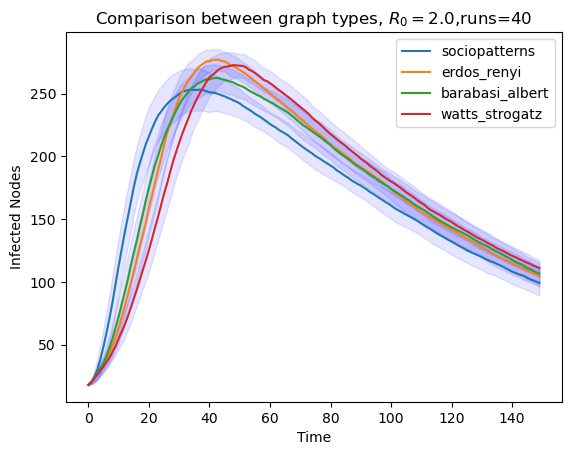

In [189]:
compare_graphtypes([],40,gs=[(g,'sociopatterns'),(er_g,'erdos_renyi'),(ba_g,'barabasi_albert'),(ws_g,'watts_strogatz')])

In [ ]:
def vaccination_experiment(strat,vac_amounts,max_time,runs,test_accuracy=1,plot=False):
    colors = ['red','blue','green','orange','black']

    mean_trends = []
    std_trends = []
    peaks = []

    for i,value in enumerate(vac_amounts):
        print(f"computing or vac amount: {value}")
        vac = Vaccination_strategy(strat,value)
        trends = []

        for run in range(runs):
            trend = simulate_network_sir(g,max_time,params,seed=0,vaccination=vac,plot=False,return_trends=True,test_accuracy=test_accuracy)[0]['trends']['node_count'][1]
            trends.append(trend)
        mean_trends.append(np.mean(trends,axis=0))
        std_trends.append(np.std(trends,axis=0))
        
        peaks.append(max(mean_trends[-1]))
        
        if plot:
            label = f"I, v={value}"
            plt.plot(range(max_time),mean_trends[-1],label=label,color=colors[i],linewidth=1)
            plt.errorbar(range(max_time),mean_trends[-1],std_trends[-1],color=colors[i],linewidth=0.5,capsize=2)
            # plt.fill_between(range(max_time), mean_trends[-1]-std_trends[-1], mean_trends[-1]+std_trends[-1], color=colors[i], alpha=0.1)

            
            plt.plot([0,max_time],[peaks[-1],peaks[-1]],color=colors[i],linewidth=0.5,linestyle='--')

    max_difference = np.array(peaks[0]) - np.array(peaks[-1])
    differences = np.array(peaks[0])-np.array(peaks)

    if plot:
        plt.xlabel('days')
        plt.ylabel('infections')
        plt.title(f'{strat} Vaccination Strategy')

        plt.xlim(0,20)
        plt.ylim(0,300)

        plt.legend()
        plt.show()

    print(f"average over {runs} runs, R0=2, beta=0.2, gamma=0.1")
    print(f"max impact = {round(max_difference,2)} = {round(max_difference*100/peaks[0],2)}%")

    return differences



computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


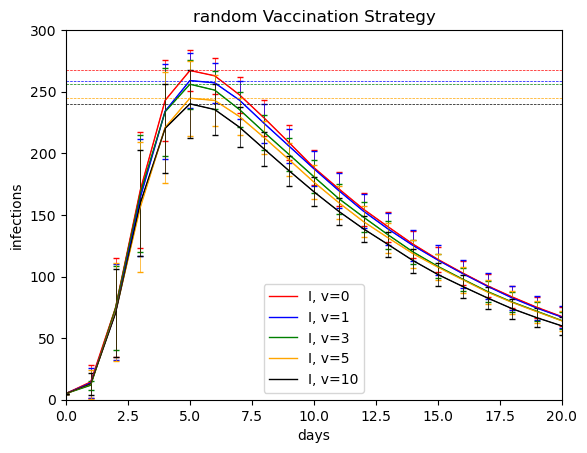

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 27.07 = 10.13%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


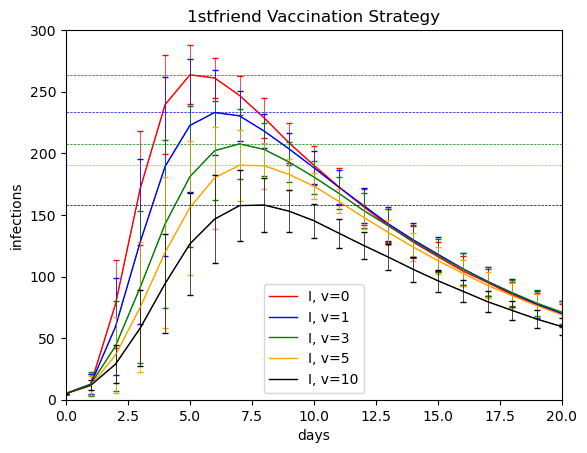

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 105.68 = 40.08%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


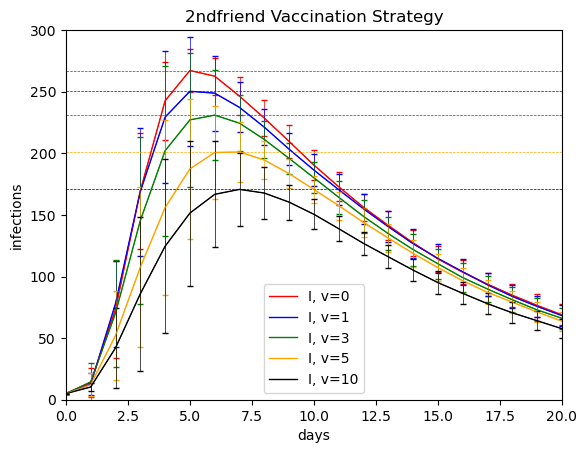

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 96.49 = 36.11%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


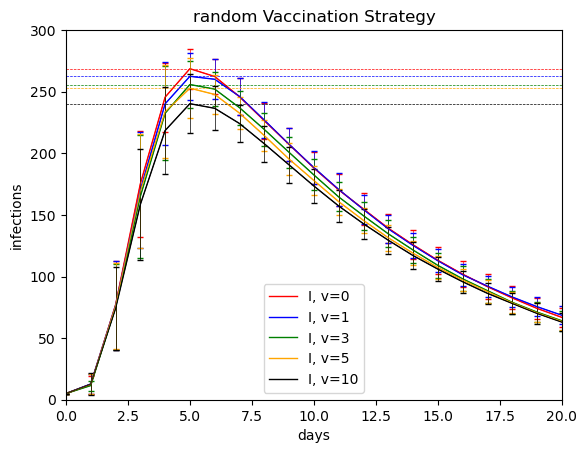

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 28.42 = 10.58%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


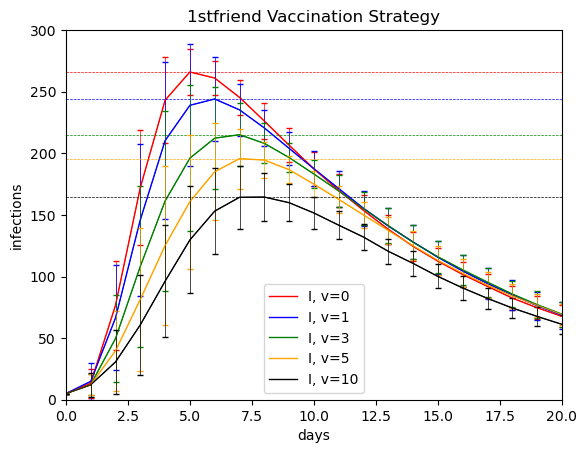

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 101.53 = 38.16%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


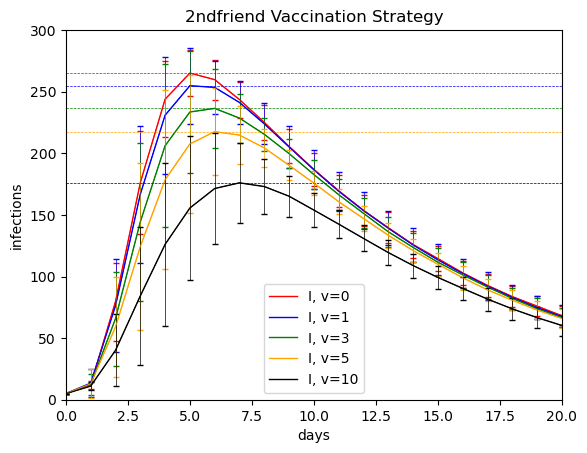

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 89.11 = 33.61%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


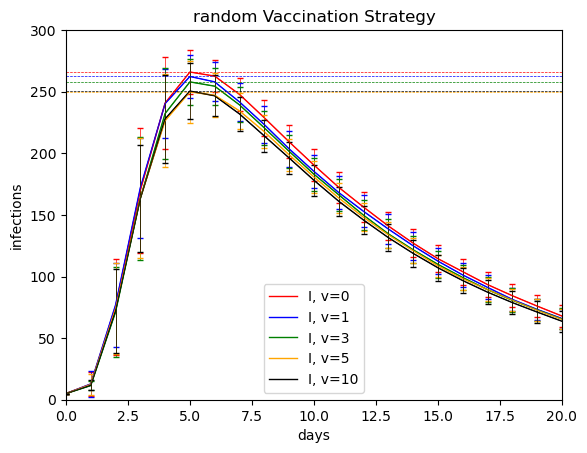

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 15.46 = 5.81%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


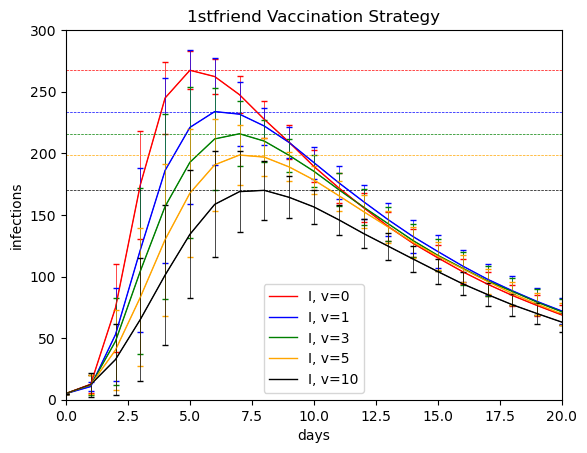

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 97.47 = 36.45%
computing or vac anount: 0
computing or vac anount: 1
computing or vac anount: 3
computing or vac anount: 5
computing or vac anount: 10


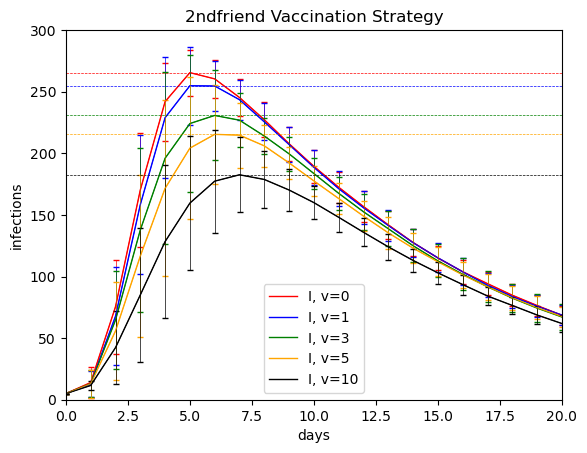

average over 100 runs, R0=2, beta=0.2, gamma=0.1
max impact = 82.91 = 31.23%


In [192]:
differences_list = {}

# Simulate SIR on this network with vaccinations
import matplotlib.pyplot as plt
params['beta'] = 0.2
params['gamma'] = 0.1
params['fraction_infected'] = 5/375
vac_amounts = [0,1,3,5,10]
accuracies = [1,0.75,0.5]
max_time = 21
runs = 100

differences_list['Random'] = {}
differences_list['First Friend'] = {}
differences_list['Second Friend'] = {}


for accuracy in accuracies:
    differences_list['Random'][accuracy] = vaccination_experiment('random',vac_amounts,max_time,runs,accuracy, plot=True)
    differences_list['First Friend'][accuracy] = vaccination_experiment('1stfriend',vac_amounts,max_time,runs,accuracy, plot=True)
    differences_list['Second Friend'][accuracy] = vaccination_experiment('2ndfriend',vac_amounts,max_time,runs,accuracy, plot=True)

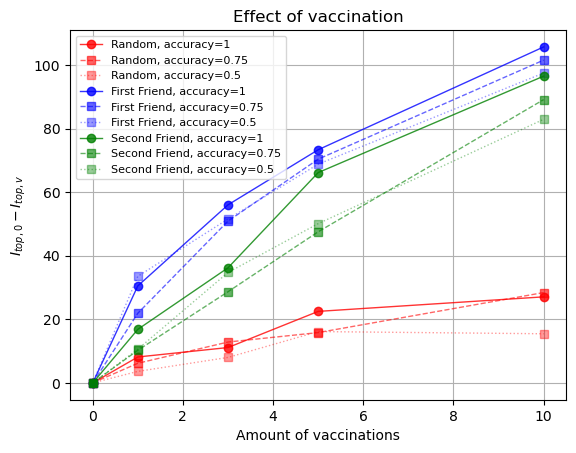

In [ ]:
colours = ['red','blue','green']
color_id = 0
for strat,dict in differences_list.items():
    i = 1
    for accuracy,difference in dict.items():
        if accuracy == 1:
            plt.plot(vac_amounts,difference, label=f"{strat}, accuracy={accuracy}",color=colours[color_id],linewidth=1,marker='o',alpha=1-0.2*i)
        elif accuracy == 0.75:
            plt.plot(vac_amounts,difference, label=f"{strat}, accuracy={accuracy}",color=colours[color_id],linewidth=1,marker='s',alpha=1-0.2*i,linestyle='--')
        elif accuracy == 0.5:
            plt.plot(vac_amounts,difference, label=f"{strat}, accuracy={accuracy}",color=colours[color_id],linewidth=1,marker='s',alpha=1-0.2*i,linestyle=':')
`x`
        i += 1
    color_id += 1
plt.ylabel(r"$I_{top,0} - I_{top,v}$")
plt.xlabel("Amount of vaccinations")
plt.title("Effect of vaccination")
plt.legend(fontsize=8)
plt.grid()
plt.show()

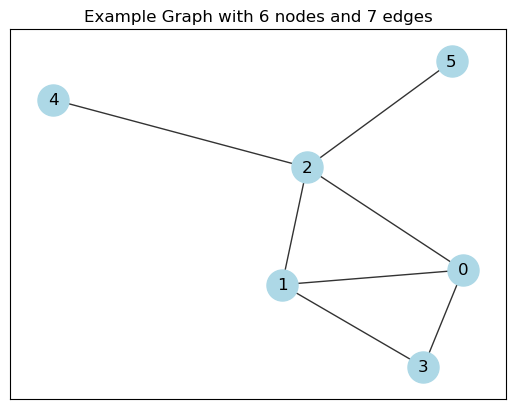

In [126]:
# make example graph with n=6, m=7 nodes and edges
example_graph = nx.Graph()
example_graph.add_edges_from([(0,1),(0,2),(0,3),(1,2),(1,3),(2,4),(2,5)])
#draw example graph
pos = nx.spring_layout(example_graph)
nx.draw_networkx_nodes(example_graph, pos, node_size=500, node_color="lightblue", alpha=1.0)
nx.draw_networkx_edges(example_graph, pos, edge_color="black", alpha=0.8)
nx.draw_networkx_labels(example_graph, pos, font_size=12, font_color="black")
plt.title("Example Graph with 6 nodes and 7 edges")
plt.show()